<a href="https://colab.research.google.com/github/kevindhuertas/transformer_model_with_time_signals/blob/main/Final_architecture_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

In [ ]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, LSTM, TimeDistributed,ReLU, Add, Conv1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2


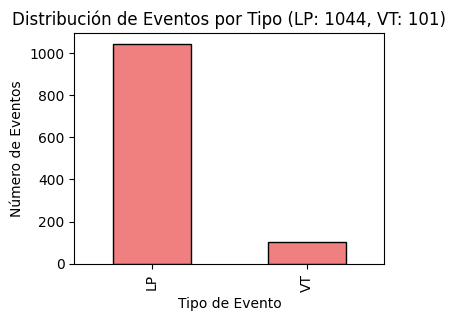

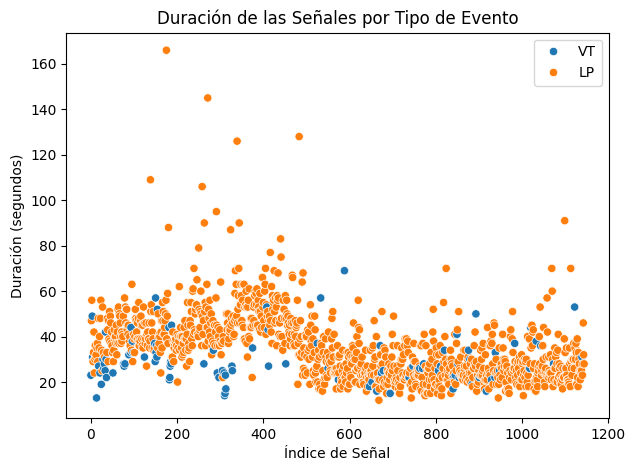

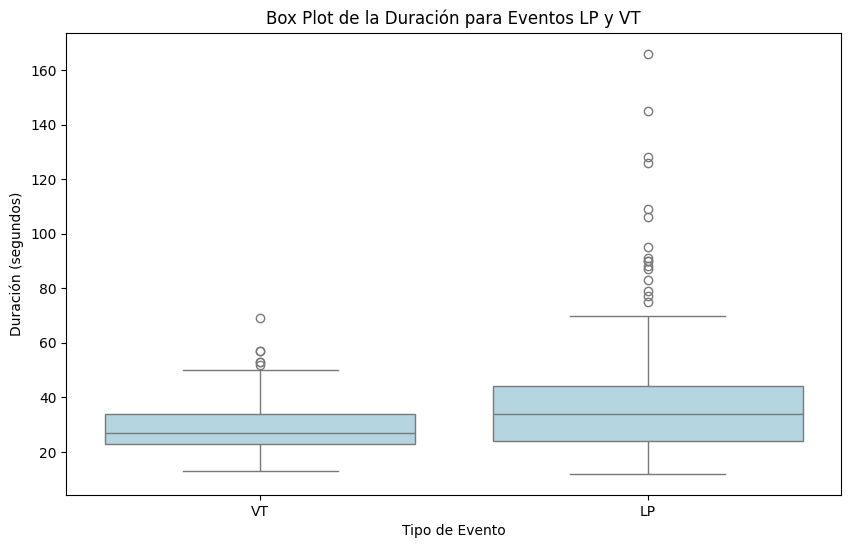

Conteo de eventos en el DataFrame original:
Type
LP          1044
VT           101
REGIONAL      27
HB             8
ICEQUAKE       7
Name: count, dtype: int64

Conteo de eventos en el DataFrame filtrado (solo LP y VT):
Type
LP    1044
VT     101
Name: count, dtype: int64

Media de la duración de las señales: 35.02 segundos
Duración fija sugerida para las señales: 36 segundos
Valor mínimo en las señales normalizadas: 0.0
Valor máximo en las señales normalizadas: 1.0


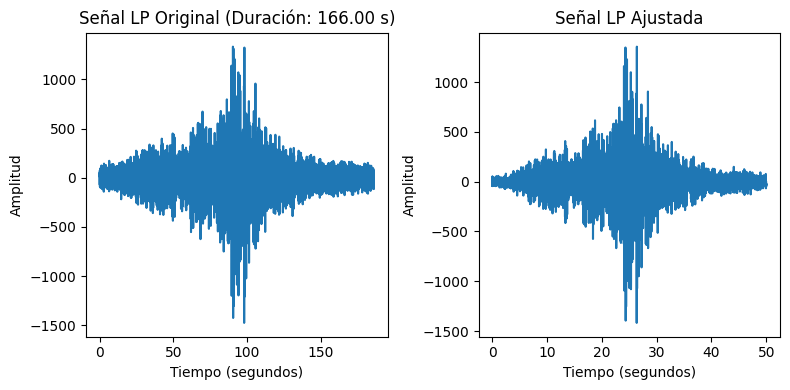

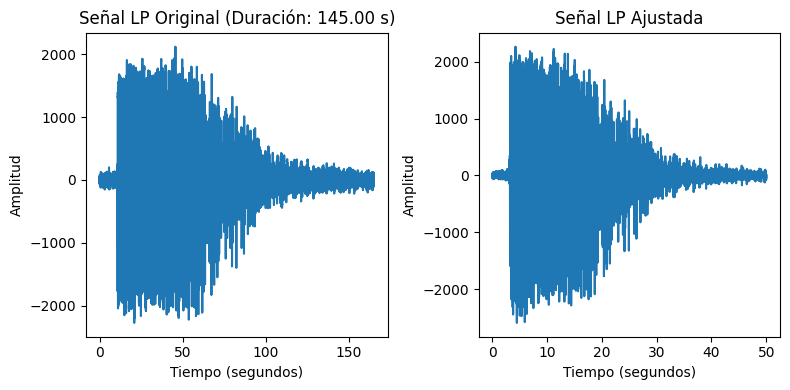

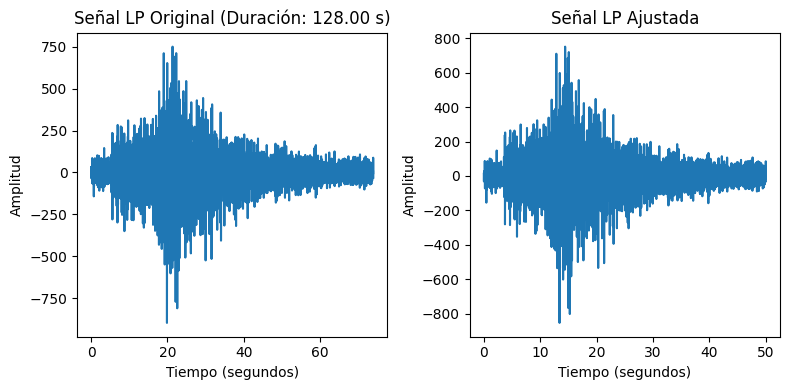

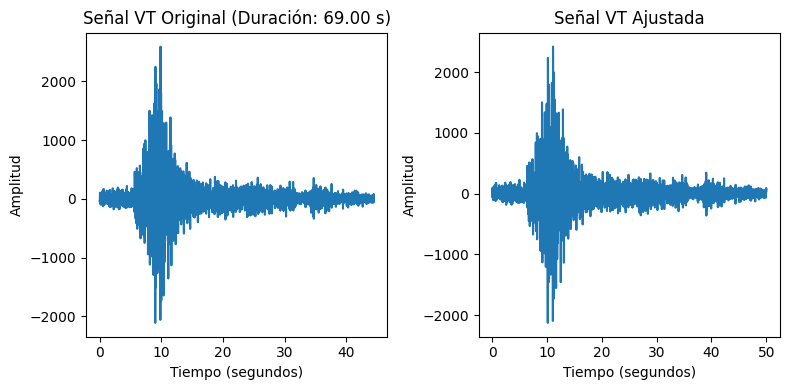

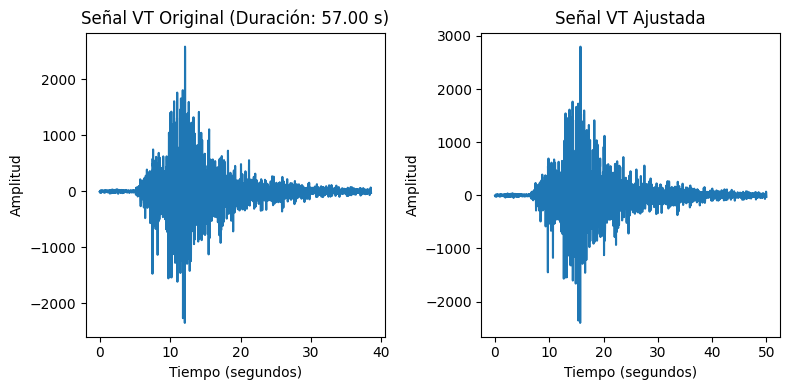

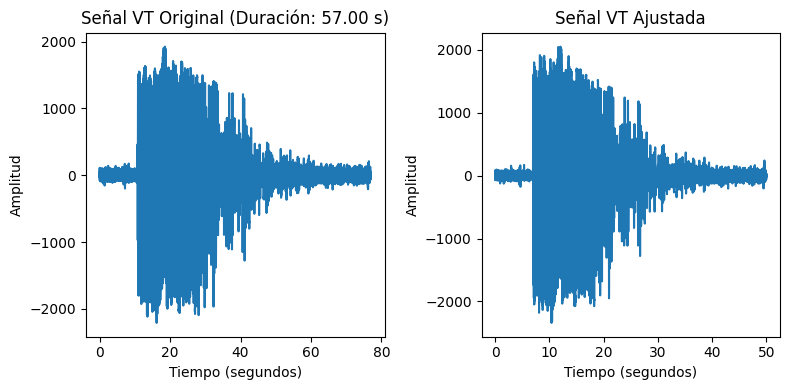

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import resample, butter, filtfilt

# df = pd.read_csv('data/data.csv')
df = pd.read_csv('./trans_data/data.csv')

df_filtered = df[df['Type'].isin(['LP', 'VT'])].reset_index(drop=True)

event_counts_filtered = df_filtered['Type'].value_counts()
event_counts_str = ', '.join([f'{idx}: {val}' for idx, val in event_counts_filtered.items()])

plt.figure(figsize=(4, 3))
event_counts_filtered.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Distribución de Eventos por Tipo (' + event_counts_str + ')')
plt.xlabel('Tipo de Evento')
plt.ylabel('Número de Eventos')
plt.show()

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_filtered, x=df_filtered.index, y='Duration', hue='Type')
plt.title('Duración de las Señales por Tipo de Evento')
plt.xlabel('Índice de Señal')
plt.ylabel('Duración (segundos)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Duration', data=df_filtered, color='lightblue')
plt.title('Box Plot de la Duración para Eventos LP y VT')
plt.xlabel('Tipo de Evento')
plt.ylabel('Duración (segundos)')
plt.show()

original_event_counts = df['Type'].value_counts()
filtered_event_counts = df_filtered['Type'].value_counts()

print(f"Conteo de eventos en el DataFrame original:\n{original_event_counts}\n")
print(f"Conteo de eventos en el DataFrame filtrado (solo LP y VT):\n{filtered_event_counts}\n")

signal_columns = [col for col in df_filtered.columns if col.startswith('Data_')]
sample_rate = 100

mean_duration = df_filtered['Duration'].mean()
print(f"Media de la duración de las señales: {mean_duration:.2f} segundos")

fixed_duration_seconds = 50
# fixed_duration_seconds = int(np.ceil(mean_duration))
print(f"Duración fija sugerida para las señales: {int(np.ceil(mean_duration))} segundos")

fixed_length = fixed_duration_seconds * sample_rate

apply_noise_removal = False

def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, signal)
    return y

adjusted_signals = []
normalized_signals = []
non_normalized_signals = []

for index, row in df_filtered.iterrows():
    signal = row[signal_columns].dropna().values.astype(np.float32)
    if len(signal) == 0:
        adjusted_signal = np.zeros(fixed_length)
    else:
        if apply_noise_removal:
            lowcut = 0.5
            highcut = 20.0
            signal = bandpass_filter(signal, lowcut, highcut, sample_rate)
        adjusted_signal = resample(signal, fixed_length)
    non_normalized_signals.append(adjusted_signal.copy())
    adjusted_signals.append(adjusted_signal)
    min_val = adjusted_signal.min()
    max_val = adjusted_signal.max()
    if max_val - min_val == 0:
        normalized_signal = adjusted_signal
    else:
        normalized_signal = (adjusted_signal - min_val) / (max_val - min_val)
    normalized_signals.append(normalized_signal)

df_filtered['AdjustedSignal'] = adjusted_signals
df_filtered['NormalizedSignal'] = normalized_signals
df_filtered['NonNormalizedSignal'] = non_normalized_signals

min_values = df_filtered['NormalizedSignal'].apply(np.min)
max_values = df_filtered['NormalizedSignal'].apply(np.max)
print(f"Valor mínimo en las señales normalizadas: {min_values.min()}")
print(f"Valor máximo en las señales normalizadas: {max_values.max()}")

lp_signals = df_filtered[df_filtered['Type'] == 'LP'].copy()
lp_signals.sort_values(by='Duration', ascending=False, inplace=True)
longest_lp_signals = lp_signals.head(3)

vt_signals = df_filtered[df_filtered['Type'] == 'VT'].copy()
vt_signals.sort_values(by='Duration', ascending=False, inplace=True)
longest_vt_signals = vt_signals.head(3)

for idx, row in longest_lp_signals.iterrows():
    original_signal = row[signal_columns].dropna().values.astype(np.float32)
    adjusted_signal = row['AdjustedSignal']
    time_original = np.linspace(0, len(original_signal) / sample_rate, len(original_signal))
    time_adjusted = np.linspace(0, fixed_duration_seconds, fixed_length)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(time_original, original_signal)
    plt.title(f'Señal LP Original (Duración: {row["Duration"]:.2f} s)')
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Amplitud')
    plt.subplot(1, 2, 2)
    plt.plot(time_adjusted, adjusted_signal)
    plt.title('Señal LP Ajustada')
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Amplitud')
    plt.tight_layout()
    plt.show()

for idx, row in longest_vt_signals.iterrows():
    original_signal = row[signal_columns].dropna().values.astype(np.float32)
    adjusted_signal = row['AdjustedSignal']
    time_original = np.linspace(0, len(original_signal) / sample_rate, len(original_signal))
    time_adjusted = np.linspace(0, fixed_duration_seconds, fixed_length)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(time_original, original_signal)
    plt.title(f'Señal VT Original (Duración: {row["Duration"]:.2f} s)')
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Amplitud')
    plt.subplot(1, 2, 2)
    plt.plot(time_adjusted, adjusted_signal)
    plt.title('Señal VT Ajustada')
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Amplitud')
    plt.tight_layout()
    plt.show()


## bests Architecture tests

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import gc
import re
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score, confusion_matrix

# Supongamos que 'df_filtered' ya está definido como tu DataFrame filtrado
X = np.array(df_filtered['NormalizedSignal'].tolist())  # Convertimos las señales a arrays
y = df_filtered['Type'].map({'VT': 0, 'LP': 1}).values  # Mapear etiquetas a enteros

# Añadimos una dimensión extra si es necesario
if len(X.shape) == 2:
    X = np.expand_dims(X, -1)

print(f"Tipo de X: {X.dtype}, Tipo de y: {y.dtype}")
print(f'Datos: {X.shape}')

# División de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Definición de la capa de codificación posicional
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self.positional_encoding_matrix(sequence_length, d_model)

    def positional_encoding_matrix(self, sequence_length, d_model):
        pos = np.arange(sequence_length)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rads = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        return tf.convert_to_tensor(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con arquitectura variable
def build_transformer_model(input_shape, num_classes, config):
    inputs = layers.Input(shape=input_shape)

    x = PositionalEncoding(input_shape[0], config['head_size'])(inputs)

    for _ in range(config.get('num_initial_conv', 0)):
        x_conv = layers.Conv1D(filters=config['conv_filters'], kernel_size=3, padding='same', activation='relu')(x)
        x_conv = layers.BatchNormalization()(x_conv)
        x = x_conv

    for _ in range(config['num_layers']):
        x = transformer_encoder(
            x,
            head_size=config['head_size'],
            num_heads=config['num_heads'],
            ff_dim=config['ff_dim'],
            num_transformer_blocks=config.get('num_transformer_blocks', 1),
            num_ff_layers=config.get('num_ff_layers', 1),
            dropout=config['dropout']
        )

    x = layers.GlobalAveragePooling1D()(x)
    for units in config.get('dense_units', []):
        x_dense = layers.Dense(units, activation='relu')(x)
        x_dense = layers.Dropout(config['dropout'])(x_dense)
        x = x_dense

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Función para parsear la configuración desde el nombre del archivo
def parse_config_from_filename(filename):
    config = {}
    # Remover 'transformer' y '.h5'
    basename = os.path.basename(filename)
    config_str = basename.replace('transformer', '').replace('.h5', '')
    # Remover el id al inicio (puede ser número o número_archXXX)
    match = re.match(r'(\d+(_arch\d+)?)_(.*)', config_str)
    if match:
        id_part, _, config_part = match.groups()
    else:
        config_part = config_str
    tokens = config_part.split('_')
    i = 0
    while i < len(tokens):
        key = tokens[i]
        value = tokens[i+1] if i+1 < len(tokens) else ''
        if key == 'du':
            # Manejar lista de unidades densas
            dense_units_str = '_'.join(tokens[i+1:])
            # Remover posibles prefijos 'du_'
            dense_units_str = dense_units_str.replace('du_', '')
            # Convertir la cadena de lista a una lista real
            dense_units = eval(dense_units_str)
            config['dense_units'] = dense_units
            break  # Salimos del bucle ya que hemos procesado el resto
        else:
            try:
                # Convertir a float o int según corresponda
                if key in ['do']:
                    config[key] = float(value)
                else:
                    config[key] = int(value)
            except ValueError:
                config[key] = value  # En caso de que no sea un número
        i += 2
    return config

# Función para generar el resumen de la arquitectura
def generate_architecture_summary(config, num_classes):
    layers_list = ['PositionalEncoding']

    # Capas Conv1D iniciales
    num_initial_conv = config.get('num_initial_conv', 0)
    conv_filters = config.get('conv_filters', None)
    if num_initial_conv > 0 and conv_filters:
        for i in range(num_initial_conv):
            layers_list.append(f'Conv1D filtros {conv_filters}')

    # Capas Transformer
    num_layers = config.get('num_layers', 1)
    num_transformer_blocks = config.get('num_transformer_blocks', 1)
    num_ff_layers = config.get('num_ff_layers', 1)
    ff_dim = config.get('ff_dim', None)

    for layer_idx in range(num_layers):
        for block_idx in range(num_transformer_blocks):
            layers_list.append('MultiHeadAttention')
            for ff_layer_idx in range(num_ff_layers):
                if ff_dim:
                    layers_list.append(f'Conv1D filtros {ff_dim}')

    layers_list.append('GlobalAveragePooling1D')

    # Capas densas
    dense_units = config.get('dense_units', [])
    for units in dense_units:
        layers_list.append(f'Dense {units}')

    layers_list.append(f'Dense {num_classes}')

    architecture_summary = '\n'.join(layers_list)
    return architecture_summary

# Función para obtener la configuración de MultiHeadAttention
def get_multihead_attention_config(config):
    head_size = config.get('head_size')
    num_heads = config.get('num_heads')
    dropout = config.get('dropout')

    mha_config = f'head_size: {head_size}, num_heads: {num_heads}, dropout: {dropout}'
    return mha_config


model_filenames = [
    'transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5',


    # 'transformer35_arch203_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_2_du_[128, 64].h5',

    # 'transformer35_arch213_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_3_nfl_3_du_[].h5',
    'transformer35_arch192_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[].h5',
    # 'transformer35_arch197_nl_1_hs_64_nh_4_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_3_du_[128, 64].h5',
    # 'transformer35_arch192_nl_1_hs_64_nh_4_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[].h5',

    # 'transformer159_arch67_nl_3_hs_64_nh_4_ff_64_do_0.2_ep_120_nic_1_cf_64_ntb_2_nfl_2_du_[64].h5',
    # 'transformer38_arch206_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_3_du_[128, 64].h5',
# ===========
    # 'transformer38_arch210_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_3_nfl_2_du_[].h5',
    # 'transformer35_arch200_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_1_du_[128, 64].h5',
    # 'transformer36_arch191_nl_2_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5',
    # 'transformer36_arch124_nl_2_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_1_cf_64_ntb_2_nfl_3_du_[64].h5',
    # 'transformer38_arch193_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[64].h5',
    # 'transformer38_arch194_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[128, 64].h5',
    # 'transformer38_arch202_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_2_du_[64].h5'
]

# Número de folds para cross-validation
n_splits = 2
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

results = []

for model_filename in model_filenames:
    config = parse_config_from_filename(model_filename)
    print(f"Configuración extraída para {model_filename}: {config}")

    # Convertir claves a las usadas en build_transformer_model
    config_keys = {
        'nl': 'num_layers',
        'hs': 'head_size',
        'nh': 'num_heads',
        'ff': 'ff_dim',
        'do': 'dropout',
        'ep': 'epochs',
        'nic': 'num_initial_conv',
        'cf': 'conv_filters',
        'ntb': 'num_transformer_blocks',
        'nfl': 'num_ff_layers',
        # 'du' ya está en config
    }
    # Renombrar las claves
    config = {config_keys.get(k, k): v for k, v in config.items()}

    # Verificar que todas las claves necesarias están presentes
    required_keys = ['num_layers', 'head_size', 'num_heads', 'ff_dim', 'dropout', 'epochs']
    missing_keys = [key for key in required_keys if key not in config]
    if missing_keys:
        print(f"Claves faltantes {missing_keys} en la configuración para {model_filename}")
        continue

    # Generar resúmenes de arquitectura y configuración de MultiHeadAttention
    architecture_summary = generate_architecture_summary(config, num_classes=2)
    mha_config = get_multihead_attention_config(config)

    # Hacer cross-validation para obtener métricas de validación
    fold_metrics = {'accuracy': [], 'loss': [], 'auc': [], 'confusion_matrices': []}

    for fold, (train_index, val_index) in enumerate(skf.split(X_train_full, y_train_full)):
        print(f"Fold {fold+1}/{n_splits} para el modelo {model_filename}")
        X_train_fold, X_val_fold = X_train_full[train_index], X_train_full[val_index]
        y_train_fold, y_val_fold = y_train_full[train_index], y_train_full[val_index]
        try:
          model = build_transformer_model(
              input_shape=(X_train_fold.shape[1], X_train_fold.shape[2]),
              num_classes=2,
              config=config
          )

          model.compile(
              optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
          )

          early_stopping = tf.keras.callbacks.EarlyStopping(
              monitor='val_loss', patience=18, restore_best_weights=True
          )

          history = model.fit(
              X_train_fold, y_train_fold,
              validation_data=(X_val_fold, y_val_fold),
              epochs=config['epochs'],
              batch_size=4,
              callbacks=[early_stopping],
              verbose=0
          )

          # Evaluar el modelo en el conjunto de validación
          y_val_probs = model.predict(X_val_fold, batch_size=4)
          y_val_pred = np.argmax(y_val_probs, axis=1)
          val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0, batch_size=4)
          val_auc = roc_auc_score(y_val_fold, y_val_probs[:, 1])
          val_confusion = confusion_matrix(y_val_fold, y_val_pred)
          fold_metrics['accuracy'].append(val_accuracy)
          fold_metrics['loss'].append(val_loss)
          fold_metrics['auc'].append(val_auc)
          fold_metrics['confusion_matrices'].append(val_confusion)

          del model
          tf.keras.backend.clear_session()
          gc.collect()
        except Exception as e:
          print(f"Error con la configuración {config}: {e}")

    avg_accuracy = np.mean(fold_metrics['accuracy'])
    avg_loss = np.mean(fold_metrics['loss'])
    avg_auc = np.mean(fold_metrics['auc'])
    # total_confusion_matrix = np.sum(fold_metrics['confusion_matrices'], axis=0)

    print(f"Resultados de validación para {model_filename}:")
    print(f"Precisión promedio en validación: {avg_accuracy:.4f}")
    print(f"Pérdida promedio en validación: {avg_loss:.4f}")
    print(f"AUC promedio en validación: {avg_auc:.4f}")
    # print(f"Matriz de confusión total en validación:\n{total_confusion_matrix}")

    # Entrenar el modelo en todo el conjunto de entrenamiento y evaluar en el conjunto de prueba
    model = build_transformer_model(
        input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
        num_classes=2,
        config=config
    )

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True
    )

    history = model.fit(
        X_train_full, y_train_full,
        validation_data=(X_test, y_test),
        epochs=config['epochs'],
        batch_size=4,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluar en el conjunto de prueba
    y_test_probs = model.predict(X_test, batch_size=4)
    y_test_pred = np.argmax(y_test_probs, axis=1)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0,batch_size=4)
    test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
    test_confusion = confusion_matrix(y_test, y_test_pred)

    print(f"Resultados en prueba para {model_filename}:")
    print(f"Precisión en prueba: {test_accuracy:.4f}")
    print(f"Pérdida en prueba: {test_loss:.4f}")
    print(f"AUC en prueba: {test_auc:.4f}")
    print(f"Matriz de confusión en prueba:\n{test_confusion}")

    # Agregar los resultados al DataFrame
    results.append({
        'model_filename': model_filename,
        'config': config,
        'architecture_summary': architecture_summary,
        'multihead_attention_config': mha_config,
        'avg_accuracy': avg_accuracy,
        'avg_loss': avg_loss,
        'avg_auc': avg_auc,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'test_auc': test_auc,
        'test_confusion_matrix': test_confusion.tolist()  # Convertir a lista para almacenar en CSV
    })

    del model
    tf.keras.backend.clear_session()
    gc.collect()

# Después de probar todos los modelos, mostrar las métricas
results.sort(key=lambda x: x['avg_accuracy'], reverse=True)

print("\nResultados de todos los modelos:")
for result in results:
    print(f"Modelo: {result['model_filename']}")
    print(f"Configuración: {result['config']}")
    print(f"Resumen de la arquitectura:\n{result['architecture_summary']}")
    print(f"Configuración de MultiHeadAttention: {result['multihead_attention_config']}")
    print(f"Precisión promedio en validación: {result['avg_accuracy']:.4f}")
    print(f"Pérdida promedio en validación: {result['avg_loss']:.4f}")
    print(f"AUC promedio en validación: {result['avg_auc']:.4f}")
    print(f"Precisión en prueba: {result['test_accuracy']:.4f}")
    print(f"Pérdida en prueba: {result['test_loss']:.4f}")
    print(f"AUC en prueba: {result['test_auc']:.4f}")
    print(f"Matriz de confusión en prueba:\n{np.array(result['test_confusion_matrix'])}\n")

# Crear un DataFrame con las mejores configuraciones y sus métricas
results_df = pd.DataFrame(results)
# print("DataFrame con las mejores configuraciones y sus métricas:")
print(results_df)
# results_df.to_csv('/content/trans_data/final_test/resultsKfol2GainModels.csv', index=False)
# print("Resultados guardados en CSV")


Tipo de X: float32, Tipo de y: int64
Datos: (1145, 5000, 1)
Configuración extraída para transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5: {'nl': 1, 'hs': 64, 'nh': 2, 'ff': 64, 'do': 0.1, 'ep': 100, 'nic': 2, 'cf': 64, 'ntb': 1, 'nfl': 1, 'dense_units': [128, 64]}
Fold 1/2 para el modelo transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5
115/115 [==============================] - 2s 14ms/step
Fold 2/2 para el modelo transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5
115/115 [==============================] - 2s 14ms/step
Resultados de validación para transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5:
Precisión promedio en validación: 0.9279
Pérdida promedio en validación: 0.2155
AUC promedio en validación: 0.8414
58/58 [==============================] - 1s 14ms/step
Resultados en prueba para transf

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import gc
import re
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score, confusion_matrix

# # Supongamos que 'df_filtered' ya está definido como tu DataFrame filtrado
# X = np.array(df_filtered['NormalizedSignal'].tolist())  # Convertimos las señales a arrays
# y = df_filtered['Type'].map({'VT': 0, 'LP': 1}).values  # Mapear etiquetas a enteros

# # Añadimos una dimensión extra si es necesario
# if len(X.shape) == 2:
#     X = np.expand_dims(X, -1)

# print(f"Tipo de X: {X.dtype}, Tipo de y: {y.dtype}")
# print(f'Datos: {X.shape}')

# # División de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
# X_train_full, X_test, y_train_full, y_test = train_test_split(
#     X, y, test_size=0.20, random_state=42, stratify=y
# )

# Definición de la capa de codificación posicional
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self.positional_encoding_matrix(sequence_length, d_model)

    def positional_encoding_matrix(self, sequence_length, d_model):
        pos = np.arange(sequence_length)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rads = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        return tf.convert_to_tensor(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con arquitectura variable
def build_transformer_model(input_shape, num_classes, config):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for _ in range(config.get('num_initial_conv', 0)):
        x_conv = layers.Conv1D(filters=config['conv_filters'], kernel_size=3, padding='same', activation='relu')(x)
        x_conv = layers.BatchNormalization()(x_conv)
        x = x_conv

    x = PositionalEncoding(input_shape[0], config['head_size'])(x)

    for _ in range(config['num_layers']):
        x = transformer_encoder(
            x,
            head_size=config['head_size'],
            num_heads=config['num_heads'],
            ff_dim=config['ff_dim'],
            num_transformer_blocks=config.get('num_transformer_blocks', 1),
            num_ff_layers=config.get('num_ff_layers', 1),
            dropout=config['dropout']
        )

    x = layers.GlobalAveragePooling1D()(x)
    for units in config.get('dense_units', []):
        x_dense = layers.Dense(units, activation='relu')(x)
        x_dense = layers.Dropout(config['dropout'])(x_dense)
        x = x_dense

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Función para parsear la configuración desde el nombre del archivo
def parse_config_from_filename(filename):
    config = {}
    # Remover 'transformer' y '.h5'
    basename = os.path.basename(filename)
    config_str = basename.replace('transformer', '').replace('.h5', '')
    # Remover el id al inicio (puede ser número o número_archXXX)
    match = re.match(r'(\d+(_arch\d+)?)_(.*)', config_str)
    if match:
        id_part, _, config_part = match.groups()
    else:
        config_part = config_str
    tokens = config_part.split('_')
    i = 0
    while i < len(tokens):
        key = tokens[i]
        value = tokens[i+1] if i+1 < len(tokens) else ''
        if key == 'du':
            # Manejar lista de unidades densas
            dense_units_str = '_'.join(tokens[i+1:])
            # Remover posibles prefijos 'du_'
            dense_units_str = dense_units_str.replace('du_', '')
            # Convertir la cadena de lista a una lista real
            dense_units = eval(dense_units_str)
            config['dense_units'] = dense_units
            break  # Salimos del bucle ya que hemos procesado el resto
        else:
            try:
                # Convertir a float o int según corresponda
                if key in ['do']:
                    config[key] = float(value)
                else:
                    config[key] = int(value)
            except ValueError:
                config[key] = value  # En caso de que no sea un número
        i += 2
    return config

# Función para generar el resumen de la arquitectura
def generate_architecture_summary(config, num_classes):
    layers_list = ['PositionalEncoding']

    # Capas Conv1D iniciales
    num_initial_conv = config.get('num_initial_conv', 0)
    conv_filters = config.get('conv_filters', None)
    if num_initial_conv > 0 and conv_filters:
        for i in range(num_initial_conv):
            layers_list.append(f'Conv1D filtros {conv_filters}')

    # Capas Transformer
    num_layers = config.get('num_layers', 1)
    num_transformer_blocks = config.get('num_transformer_blocks', 1)
    num_ff_layers = config.get('num_ff_layers', 1)
    ff_dim = config.get('ff_dim', None)

    for layer_idx in range(num_layers):
        for block_idx in range(num_transformer_blocks):
            layers_list.append('MultiHeadAttention')
            for ff_layer_idx in range(num_ff_layers):
                if ff_dim:
                    layers_list.append(f'Conv1D filtros {ff_dim}')

    layers_list.append('GlobalAveragePooling1D')

    # Capas densas
    dense_units = config.get('dense_units', [])
    for units in dense_units:
        layers_list.append(f'Dense {units}')

    layers_list.append(f'Dense {num_classes}')

    architecture_summary = '\n'.join(layers_list)
    return architecture_summary

# Función para obtener la configuración de MultiHeadAttention
def get_multihead_attention_config(config):
    head_size = config.get('head_size')
    num_heads = config.get('num_heads')
    dropout = config.get('dropout')

    mha_config = f'head_size: {head_size}, num_heads: {num_heads}, dropout: {dropout}'
    return mha_config


model_filenames = [
    'transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5',


    # 'transformer35_arch203_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_2_du_[128, 64].h5',

    # 'transformer35_arch213_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_3_nfl_3_du_[].h5',
    # === 'transformer35_arch192_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[].h5',
    # 'transformer35_arch197_nl_1_hs_64_nh_4_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_3_du_[128, 64].h5',
    # 'transformer35_arch192_nl_1_hs_64_nh_4_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[].h5',

    # 'transformer159_arch67_nl_3_hs_64_nh_4_ff_64_do_0.2_ep_120_nic_1_cf_64_ntb_2_nfl_2_du_[64].h5',
    # 'transformer38_arch206_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_3_du_[128, 64].h5',
# ===========
    # 'transformer38_arch210_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_3_nfl_2_du_[].h5',
    # 'transformer35_arch200_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_1_du_[128, 64].h5',
    # 'transformer36_arch191_nl_2_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5',
    # 'transformer36_arch124_nl_2_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_1_cf_64_ntb_2_nfl_3_du_[64].h5',
    # 'transformer38_arch193_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[64].h5',
    # 'transformer38_arch194_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[128, 64].h5',
    # 'transformer38_arch202_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_2_du_[64].h5'
]

# Número de folds para cross-validation
n_splits = 2
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

results = []

for model_filename in model_filenames:
    config = parse_config_from_filename(model_filename)
    print(f"Configuración extraída para {model_filename}: {config}")

    # Convertir claves a las usadas en build_transformer_model
    config_keys = {
        'nl': 'num_layers',
        'hs': 'head_size',
        'nh': 'num_heads',
        'ff': 'ff_dim',
        'do': 'dropout',
        'ep': 'epochs',
        'nic': 'num_initial_conv',
        'cf': 'conv_filters',
        'ntb': 'num_transformer_blocks',
        'nfl': 'num_ff_layers',
        # 'du' ya está en config
    }
    # Renombrar las claves
    config = {config_keys.get(k, k): v for k, v in config.items()}

    # Verificar que todas las claves necesarias están presentes
    required_keys = ['num_layers', 'head_size', 'num_heads', 'ff_dim', 'dropout', 'epochs']
    missing_keys = [key for key in required_keys if key not in config]
    if missing_keys:
        print(f"Claves faltantes {missing_keys} en la configuración para {model_filename}")
        continue

    # Generar resúmenes de arquitectura y configuración de MultiHeadAttention
    architecture_summary = generate_architecture_summary(config, num_classes=2)
    mha_config = get_multihead_attention_config(config)

    # Hacer cross-validation para obtener métricas de validación
    fold_metrics = {'accuracy': [], 'loss': [], 'auc': [], 'confusion_matrices': []}

    for fold, (train_index, val_index) in enumerate(skf.split(X_train_full, y_train_full)):
        print(f"Fold {fold+1}/{n_splits} para el modelo {model_filename}")
        X_train_fold, X_val_fold = X_train_full[train_index], X_train_full[val_index]
        y_train_fold, y_val_fold = y_train_full[train_index], y_train_full[val_index]
        try:
          model = build_transformer_model(
              input_shape=(X_train_fold.shape[1], X_train_fold.shape[2]),
              num_classes=2,
              config=config
          )

          model.compile(
              optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
          )

          early_stopping = tf.keras.callbacks.EarlyStopping(
              monitor='val_loss', patience=18, restore_best_weights=True
          )

          history = model.fit(
              X_train_fold, y_train_fold,
              validation_data=(X_val_fold, y_val_fold),
              epochs=config['epochs'],
              batch_size=4,
              callbacks=[early_stopping],
              verbose=0
          )

          # Evaluar el modelo en el conjunto de validación
          y_val_probs = model.predict(X_val_fold, batch_size=4)
          y_val_pred = np.argmax(y_val_probs, axis=1)
          val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0, batch_size=4)
          val_auc = roc_auc_score(y_val_fold, y_val_probs[:, 1])
          val_confusion = confusion_matrix(y_val_fold, y_val_pred)
          fold_metrics['accuracy'].append(val_accuracy)
          fold_metrics['loss'].append(val_loss)
          fold_metrics['auc'].append(val_auc)
          fold_metrics['confusion_matrices'].append(val_confusion)

          del model
          tf.keras.backend.clear_session()
          gc.collect()
        except Exception as e:
          print(f"Error con la configuración {config}: {e}")

    avg_accuracy = np.mean(fold_metrics['accuracy'])
    avg_loss = np.mean(fold_metrics['loss'])
    avg_auc = np.mean(fold_metrics['auc'])
    # total_confusion_matrix = np.sum(fold_metrics['confusion_matrices'], axis=0)

    print(f"Resultados de validación para {model_filename}:")
    print(f"Precisión promedio en validación: {avg_accuracy:.4f}")
    print(f"Pérdida promedio en validación: {avg_loss:.4f}")
    print(f"AUC promedio en validación: {avg_auc:.4f}")
    # print(f"Matriz de confusión total en validación:\n{total_confusion_matrix}")

    # Entrenar el modelo en todo el conjunto de entrenamiento y evaluar en el conjunto de prueba
    model = build_transformer_model(
        input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
        num_classes=2,
        config=config
    )

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True
    )

    history = model.fit(
        X_train_full, y_train_full,
        validation_data=(X_test, y_test),
        epochs=config['epochs'],
        batch_size=4,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluar en el conjunto de prueba
    y_test_probs = model.predict(X_test, batch_size=4)
    y_test_pred = np.argmax(y_test_probs, axis=1)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0,batch_size=4)
    test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
    test_confusion = confusion_matrix(y_test, y_test_pred)

    print(f"Resultados en prueba para {model_filename}:")
    print(f"Precisión en prueba: {test_accuracy:.4f}")
    print(f"Pérdida en prueba: {test_loss:.4f}")
    print(f"AUC en prueba: {test_auc:.4f}")
    print(f"Matriz de confusión en prueba:\n{test_confusion}")

    # Agregar los resultados al DataFrame
    results.append({
        'model_filename': model_filename,
        'config': config,
        'architecture_summary': architecture_summary,
        'multihead_attention_config': mha_config,
        'avg_accuracy': avg_accuracy,
        'avg_loss': avg_loss,
        'avg_auc': avg_auc,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'test_auc': test_auc,
        'test_confusion_matrix': test_confusion.tolist()  # Convertir a lista para almacenar en CSV
    })

    del model
    tf.keras.backend.clear_session()
    gc.collect()

# Después de probar todos los modelos, mostrar las métricas
results.sort(key=lambda x: x['avg_accuracy'], reverse=True)

print("\nResultados de todos los modelos:")
for result in results:
    print(f"Modelo: {result['model_filename']}")
    print(f"Configuración: {result['config']}")
    print(f"Resumen de la arquitectura:\n{result['architecture_summary']}")
    print(f"Configuración de MultiHeadAttention: {result['multihead_attention_config']}")
    print(f"Precisión promedio en validación: {result['avg_accuracy']:.4f}")
    print(f"Pérdida promedio en validación: {result['avg_loss']:.4f}")
    print(f"AUC promedio en validación: {result['avg_auc']:.4f}")
    print(f"Precisión en prueba: {result['test_accuracy']:.4f}")
    print(f"Pérdida en prueba: {result['test_loss']:.4f}")
    print(f"AUC en prueba: {result['test_auc']:.4f}")
    print(f"Matriz de confusión en prueba:\n{np.array(result['test_confusion_matrix'])}\n")

# Crear un DataFrame con las mejores configuraciones y sus métricas
results_df = pd.DataFrame(results)
# print("DataFrame con las mejores configuraciones y sus métricas:")
print(results_df)
# results_df.to_csv('/content/trans_data/final_test/resultsKfol2GainModels.csv', index=False)
# print("Resultados guardados en CSV")


Configuración extraída para transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5: {'nl': 1, 'hs': 64, 'nh': 2, 'ff': 64, 'do': 0.1, 'ep': 100, 'nic': 2, 'cf': 64, 'ntb': 1, 'nfl': 1, 'dense_units': [128, 64]}
Fold 1/2 para el modelo transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5
115/115 [==============================] - 2s 15ms/step
Fold 2/2 para el modelo transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5
115/115 [==============================] - 2s 14ms/step
Resultados de validación para transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5:
Precisión promedio en validación: 0.9476
Pérdida promedio en validación: 0.1604
AUC promedio en validación: 0.9433
58/58 [==============================] - 1s 15ms/step
Resultados en prueba para transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf

### Arquitectura con maxpool1D

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import gc
import re
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score, confusion_matrix

# # Supongamos que 'df_filtered' ya está definido como tu DataFrame filtrado
# X = np.array(df_filtered['NormalizedSignal'].tolist())  # Convertimos las señales a arrays
# y = df_filtered['Type'].map({'VT': 0, 'LP': 1}).values  # Mapear etiquetas a enteros

# # Añadimos una dimensión extra si es necesario
# if len(X.shape) == 2:
#     X = np.expand_dims(X, -1)

# print(f"Tipo de X: {X.dtype}, Tipo de y: {y.dtype}")
# print(f'Datos: {X.shape}')

# # División de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
# X_train_full, X_test, y_train_full, y_test = train_test_split(
#     X, y, test_size=0.20, random_state=42, stratify=y
# )

# Definición de la capa de codificación posicional
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self.positional_encoding_matrix(sequence_length, d_model)

    def positional_encoding_matrix(self, sequence_length, d_model):
        pos = np.arange(sequence_length)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rads = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        return tf.convert_to_tensor(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con arquitectura variable
def build_transformer_model(input_shape, num_classes, config):
    inputs = layers.Input(shape=input_shape)

    x = PositionalEncoding(input_shape[0], config['head_size'])(inputs)

    for _ in range(config.get('num_initial_conv', 0)):
        x_conv = layers.Conv1D(filters=config['conv_filters'], kernel_size=3, padding='same', activation='relu')(x)
        x_conv = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x_conv)
        x_conv = layers.BatchNormalization()(x_conv)
        x = x_conv

    for _ in range(config['num_layers']):
        x = transformer_encoder(
            x,
            head_size=config['head_size'],
            num_heads=config['num_heads'],
            ff_dim=config['ff_dim'],
            num_transformer_blocks=config.get('num_transformer_blocks', 1),
            num_ff_layers=config.get('num_ff_layers', 1),
            dropout=config['dropout']
        )

    x = layers.GlobalAveragePooling1D()(x)
    for units in config.get('dense_units', []):
        x_dense = layers.Dense(units, activation='relu')(x)
        x_dense = layers.Dropout(config['dropout'])(x_dense)
        x = x_dense

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Función para parsear la configuración desde el nombre del archivo
def parse_config_from_filename(filename):
    config = {}
    # Remover 'transformer' y '.h5'
    basename = os.path.basename(filename)
    config_str = basename.replace('transformer', '').replace('.h5', '')
    # Remover el id al inicio (puede ser número o número_archXXX)
    match = re.match(r'(\d+(_arch\d+)?)_(.*)', config_str)
    if match:
        id_part, _, config_part = match.groups()
    else:
        config_part = config_str
    tokens = config_part.split('_')
    i = 0
    while i < len(tokens):
        key = tokens[i]
        value = tokens[i+1] if i+1 < len(tokens) else ''
        if key == 'du':
            # Manejar lista de unidades densas
            dense_units_str = '_'.join(tokens[i+1:])
            # Remover posibles prefijos 'du_'
            dense_units_str = dense_units_str.replace('du_', '')
            # Convertir la cadena de lista a una lista real
            dense_units = eval(dense_units_str)
            config['dense_units'] = dense_units
            break  # Salimos del bucle ya que hemos procesado el resto
        else:
            try:
                # Convertir a float o int según corresponda
                if key in ['do']:
                    config[key] = float(value)
                else:
                    config[key] = int(value)
            except ValueError:
                config[key] = value  # En caso de que no sea un número
        i += 2
    return config

# Función para generar el resumen de la arquitectura
def generate_architecture_summary(config, num_classes):
    layers_list = ['PositionalEncoding']

    # Capas Conv1D iniciales
    num_initial_conv = config.get('num_initial_conv', 0)
    conv_filters = config.get('conv_filters', None)
    if num_initial_conv > 0 and conv_filters:
        for i in range(num_initial_conv):
            layers_list.append(f'Conv1D filtros {conv_filters}')

    # Capas Transformer
    num_layers = config.get('num_layers', 1)
    num_transformer_blocks = config.get('num_transformer_blocks', 1)
    num_ff_layers = config.get('num_ff_layers', 1)
    ff_dim = config.get('ff_dim', None)

    for layer_idx in range(num_layers):
        for block_idx in range(num_transformer_blocks):
            layers_list.append('MultiHeadAttention')
            for ff_layer_idx in range(num_ff_layers):
                if ff_dim:
                    layers_list.append(f'Conv1D filtros {ff_dim}')

    layers_list.append('GlobalAveragePooling1D')

    # Capas densas
    dense_units = config.get('dense_units', [])
    for units in dense_units:
        layers_list.append(f'Dense {units}')

    layers_list.append(f'Dense {num_classes}')

    architecture_summary = '\n'.join(layers_list)
    return architecture_summary

# Función para obtener la configuración de MultiHeadAttention
def get_multihead_attention_config(config):
    head_size = config.get('head_size')
    num_heads = config.get('num_heads')
    dropout = config.get('dropout')

    mha_config = f'head_size: {head_size}, num_heads: {num_heads}, dropout: {dropout}'
    return mha_config


model_filenames = [
    'transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5',


    # 'transformer35_arch203_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_2_du_[128, 64].h5',

    # 'transformer35_arch213_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_3_nfl_3_du_[].h5',
    # ===== 'transformer35_arch192_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[].h5',
    # 'transformer35_arch197_nl_1_hs_64_nh_4_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_3_du_[128, 64].h5',
    # 'transformer35_arch192_nl_1_hs_64_nh_4_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[].h5',

    # 'transformer159_arch67_nl_3_hs_64_nh_4_ff_64_do_0.2_ep_120_nic_1_cf_64_ntb_2_nfl_2_du_[64].h5',
    # 'transformer38_arch206_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_3_du_[128, 64].h5',
# ===========
    # 'transformer38_arch210_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_3_nfl_2_du_[].h5',
    # 'transformer35_arch200_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_1_du_[128, 64].h5',
    # 'transformer36_arch191_nl_2_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5',
    # 'transformer36_arch124_nl_2_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_1_cf_64_ntb_2_nfl_3_du_[64].h5',
    # 'transformer38_arch193_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[64].h5',
    # 'transformer38_arch194_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[128, 64].h5',
    # 'transformer38_arch202_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_2_du_[64].h5'
]

# Número de folds para cross-validation
n_splits = 2
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

results = []

for model_filename in model_filenames:
    config = parse_config_from_filename(model_filename)
    print(f"Configuración extraída para {model_filename}: {config}")

    # Convertir claves a las usadas en build_transformer_model
    config_keys = {
        'nl': 'num_layers',
        'hs': 'head_size',
        'nh': 'num_heads',
        'ff': 'ff_dim',
        'do': 'dropout',
        'ep': 'epochs',
        'nic': 'num_initial_conv',
        'cf': 'conv_filters',
        'ntb': 'num_transformer_blocks',
        'nfl': 'num_ff_layers',
        # 'du' ya está en config
    }
    # Renombrar las claves
    config = {config_keys.get(k, k): v for k, v in config.items()}

    # Verificar que todas las claves necesarias están presentes
    required_keys = ['num_layers', 'head_size', 'num_heads', 'ff_dim', 'dropout', 'epochs']
    missing_keys = [key for key in required_keys if key not in config]
    if missing_keys:
        print(f"Claves faltantes {missing_keys} en la configuración para {model_filename}")
        continue

    # Generar resúmenes de arquitectura y configuración de MultiHeadAttention
    architecture_summary = generate_architecture_summary(config, num_classes=2)
    mha_config = get_multihead_attention_config(config)

    # Hacer cross-validation para obtener métricas de validación
    fold_metrics = {'accuracy': [], 'loss': [], 'auc': [], 'confusion_matrices': []}

    for fold, (train_index, val_index) in enumerate(skf.split(X_train_full, y_train_full)):
        print(f"Fold {fold+1}/{n_splits} para el modelo {model_filename}")
        X_train_fold, X_val_fold = X_train_full[train_index], X_train_full[val_index]
        y_train_fold, y_val_fold = y_train_full[train_index], y_train_full[val_index]
        try:
          model = build_transformer_model(
              input_shape=(X_train_fold.shape[1], X_train_fold.shape[2]),
              num_classes=2,
              config=config
          )

          model.compile(
              optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
          )

          early_stopping = tf.keras.callbacks.EarlyStopping(
              monitor='val_loss', patience=18, restore_best_weights=True
          )

          history = model.fit(
              X_train_fold, y_train_fold,
              validation_data=(X_val_fold, y_val_fold),
              epochs=config['epochs'],
              batch_size=4,
              callbacks=[early_stopping],
              verbose=0
          )

          # Evaluar el modelo en el conjunto de validación
          y_val_probs = model.predict(X_val_fold, batch_size=4)
          y_val_pred = np.argmax(y_val_probs, axis=1)
          val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0, batch_size=4)
          val_auc = roc_auc_score(y_val_fold, y_val_probs[:, 1])
          val_confusion = confusion_matrix(y_val_fold, y_val_pred)
          fold_metrics['accuracy'].append(val_accuracy)
          fold_metrics['loss'].append(val_loss)
          fold_metrics['auc'].append(val_auc)
          fold_metrics['confusion_matrices'].append(val_confusion)

          del model
          tf.keras.backend.clear_session()
          gc.collect()
        except Exception as e:
          print(f"Error con la configuración {config}: {e}")

    avg_accuracy = np.mean(fold_metrics['accuracy'])
    avg_loss = np.mean(fold_metrics['loss'])
    avg_auc = np.mean(fold_metrics['auc'])
    # total_confusion_matrix = np.sum(fold_metrics['confusion_matrices'], axis=0)

    print(f"Resultados de validación para {model_filename}:")
    print(f"Precisión promedio en validación: {avg_accuracy:.4f}")
    print(f"Pérdida promedio en validación: {avg_loss:.4f}")
    print(f"AUC promedio en validación: {avg_auc:.4f}")
    # print(f"Matriz de confusión total en validación:\n{total_confusion_matrix}")

    # Entrenar el modelo en todo el conjunto de entrenamiento y evaluar en el conjunto de prueba
    model = build_transformer_model(
        input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
        num_classes=2,
        config=config
    )

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True
    )

    history = model.fit(
        X_train_full, y_train_full,
        validation_data=(X_test, y_test),
        epochs=config['epochs'],
        batch_size=4,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluar en el conjunto de prueba
    y_test_probs = model.predict(X_test, batch_size=4)
    y_test_pred = np.argmax(y_test_probs, axis=1)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0,batch_size=4)
    test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
    test_confusion = confusion_matrix(y_test, y_test_pred)

    print(f"Resultados en prueba para {model_filename}:")
    print(f"Precisión en prueba: {test_accuracy:.4f}")
    print(f"Pérdida en prueba: {test_loss:.4f}")
    print(f"AUC en prueba: {test_auc:.4f}")
    print(f"Matriz de confusión en prueba:\n{test_confusion}")

    # Agregar los resultados al DataFrame
    results.append({
        'model_filename': model_filename,
        'config': config,
        'architecture_summary': architecture_summary,
        'multihead_attention_config': mha_config,
        'avg_accuracy': avg_accuracy,
        'avg_loss': avg_loss,
        'avg_auc': avg_auc,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'test_auc': test_auc,
        'test_confusion_matrix': test_confusion.tolist()  # Convertir a lista para almacenar en CSV
    })

    del model
    tf.keras.backend.clear_session()
    gc.collect()

# Después de probar todos los modelos, mostrar las métricas
results.sort(key=lambda x: x['avg_accuracy'], reverse=True)

print("\nResultados de todos los modelos:")
for result in results:
    print(f"Modelo: {result['model_filename']}")
    print(f"Configuración: {result['config']}")
    print(f"Resumen de la arquitectura:\n{result['architecture_summary']}")
    print(f"Configuración de MultiHeadAttention: {result['multihead_attention_config']}")
    print(f"Precisión promedio en validación: {result['avg_accuracy']:.4f}")
    print(f"Pérdida promedio en validación: {result['avg_loss']:.4f}")
    print(f"AUC promedio en validación: {result['avg_auc']:.4f}")
    print(f"Precisión en prueba: {result['test_accuracy']:.4f}")
    print(f"Pérdida en prueba: {result['test_loss']:.4f}")
    print(f"AUC en prueba: {result['test_auc']:.4f}")
    print(f"Matriz de confusión en prueba:\n{np.array(result['test_confusion_matrix'])}\n")

# Crear un DataFrame con las mejores configuraciones y sus métricas
results_df = pd.DataFrame(results)
# print("DataFrame con las mejores configuraciones y sus métricas:")
print(results_df)
# results_df.to_csv('/content/trans_data/final_test/resultsKfol2GainModels.csv', index=False)
# print("Resultados guardados en CSV")


Configuración extraída para transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5: {'nl': 1, 'hs': 64, 'nh': 2, 'ff': 64, 'do': 0.1, 'ep': 100, 'nic': 2, 'cf': 64, 'ntb': 1, 'nfl': 1, 'dense_units': [128, 64]}
Fold 1/2 para el modelo transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5
115/115 [==============================] - 2s 16ms/step
Fold 2/2 para el modelo transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5
115/115 [==============================] - 2s 16ms/step
Resultados de validación para transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5:
Precisión promedio en validación: 0.9345
Pérdida promedio en validación: 0.1873
AUC promedio en validación: 0.9161
58/58 [==============================] - 1s 14ms/step
Resultados en prueba para transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import gc
import re
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score, confusion_matrix
# Definición de la capa de codificación posicional
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self.positional_encoding_matrix(sequence_length, d_model)

    def positional_encoding_matrix(self, sequence_length, d_model):
        pos = np.arange(sequence_length)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rads = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        return tf.convert_to_tensor(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con arquitectura variable
def build_transformer_model(input_shape, num_classes, config):
    inputs = layers.Input(shape=input_shape)

    x = PositionalEncoding(input_shape[0], config['head_size'])(inputs)

    for _ in range(config.get('num_initial_conv', 0)):
        x_conv = layers.Conv1D(filters=config['conv_filters'], kernel_size=3, padding='same', activation='relu')(x)
        x_conv = layers.BatchNormalization()(x_conv)
        # x_conv = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x_conv)
        x = x_conv

    for _ in range(config['num_layers']):
        x = transformer_encoder(
            x,
            head_size=config['head_size'],
            num_heads=config['num_heads'],
            ff_dim=config['ff_dim'],
            num_transformer_blocks=config.get('num_transformer_blocks', 1),
            num_ff_layers=config.get('num_ff_layers', 1),
            dropout=config['dropout']
        )

    x = layers.GlobalAveragePooling1D()(x)
    for units in config.get('dense_units', []):
        x_dense = layers.Dense(units, activation='relu')(x)
        x_dense = layers.Dropout(config['dropout'])(x_dense)
        x = x_dense

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Función para parsear la configuración desde el nombre del archivo
def parse_config_from_filename(filename):
    config = {}
    # Remover 'transformer' y '.h5'
    basename = os.path.basename(filename)
    config_str = basename.replace('transformer', '').replace('.h5', '')
    # Remover el id al inicio (puede ser número o número_archXXX)
    match = re.match(r'(\d+(_arch\d+)?)_(.*)', config_str)
    if match:
        id_part, _, config_part = match.groups()
    else:
        config_part = config_str
    tokens = config_part.split('_')
    i = 0
    while i < len(tokens):
        key = tokens[i]
        value = tokens[i+1] if i+1 < len(tokens) else ''
        if key == 'du':
            # Manejar lista de unidades densas
            dense_units_str = '_'.join(tokens[i+1:])
            # Remover posibles prefijos 'du_'
            dense_units_str = dense_units_str.replace('du_', '')
            # Convertir la cadena de lista a una lista real
            dense_units = eval(dense_units_str)
            config['dense_units'] = dense_units
            break  # Salimos del bucle ya que hemos procesado el resto
        else:
            try:
                # Convertir a float o int según corresponda
                if key in ['do']:
                    config[key] = float(value)
                else:
                    config[key] = int(value)
            except ValueError:
                config[key] = value  # En caso de que no sea un número
        i += 2
    return config

# Función para generar el resumen de la arquitectura
def generate_architecture_summary(config, num_classes):
    layers_list = ['PositionalEncoding']

    # Capas Conv1D iniciales
    num_initial_conv = config.get('num_initial_conv', 0)
    conv_filters = config.get('conv_filters', None)
    if num_initial_conv > 0 and conv_filters:
        for i in range(num_initial_conv):
            layers_list.append(f'Conv1D filtros {conv_filters}')

    # Capas Transformer
    num_layers = config.get('num_layers', 1)
    num_transformer_blocks = config.get('num_transformer_blocks', 1)
    num_ff_layers = config.get('num_ff_layers', 1)
    ff_dim = config.get('ff_dim', None)

    for layer_idx in range(num_layers):
        for block_idx in range(num_transformer_blocks):
            layers_list.append('MultiHeadAttention')
            for ff_layer_idx in range(num_ff_layers):
                if ff_dim:
                    layers_list.append(f'Conv1D filtros {ff_dim}')

    layers_list.append('GlobalAveragePooling1D')

    # Capas densas
    dense_units = config.get('dense_units', [])
    for units in dense_units:
        layers_list.append(f'Dense {units}')

    layers_list.append(f'Dense {num_classes}')

    architecture_summary = '\n'.join(layers_list)
    return architecture_summary

# Función para obtener la configuración de MultiHeadAttention
def get_multihead_attention_config(config):
    head_size = config.get('head_size')
    num_heads = config.get('num_heads')
    dropout = config.get('dropout')

    mha_config = f'head_size: {head_size}, num_heads: {num_heads}, dropout: {dropout}'
    return mha_config


model_filenames = [
    'transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5',


    # 'transformer35_arch203_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_2_du_[128, 64].h5',

    # 'transformer35_arch213_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_3_nfl_3_du_[].h5',
    # ===== 'transformer35_arch192_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[].h5',
    # 'transformer35_arch197_nl_1_hs_64_nh_4_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_3_du_[128, 64].h5',
    # 'transformer35_arch192_nl_1_hs_64_nh_4_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[].h5',

    # 'transformer159_arch67_nl_3_hs_64_nh_4_ff_64_do_0.2_ep_120_nic_1_cf_64_ntb_2_nfl_2_du_[64].h5',
    # 'transformer38_arch206_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_3_du_[128, 64].h5',
# ===========
    # 'transformer38_arch210_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_3_nfl_2_du_[].h5',
    # 'transformer35_arch200_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_1_du_[128, 64].h5',
    # 'transformer36_arch191_nl_2_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5',
    # 'transformer36_arch124_nl_2_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_1_cf_64_ntb_2_nfl_3_du_[64].h5',
    # 'transformer38_arch193_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[64].h5',
    # 'transformer38_arch194_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[128, 64].h5',
    # 'transformer38_arch202_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_2_du_[64].h5'
]

# Número de folds para cross-validation
n_splits = 2
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

results = []

for model_filename in model_filenames:
    config = parse_config_from_filename(model_filename)
    print(f"Configuración extraída para {model_filename}: {config}")

    # Convertir claves a las usadas en build_transformer_model
    config_keys = {
        'nl': 'num_layers',
        'hs': 'head_size',
        'nh': 'num_heads',
        'ff': 'ff_dim',
        'do': 'dropout',
        'ep': 'epochs',
        'nic': 'num_initial_conv',
        'cf': 'conv_filters',
        'ntb': 'num_transformer_blocks',
        'nfl': 'num_ff_layers',
        # 'du' ya está en config
    }
    # Renombrar las claves
    config = {config_keys.get(k, k): v for k, v in config.items()}

    # Verificar que todas las claves necesarias están presentes
    required_keys = ['num_layers', 'head_size', 'num_heads', 'ff_dim', 'dropout', 'epochs']
    missing_keys = [key for key in required_keys if key not in config]
    if missing_keys:
        print(f"Claves faltantes {missing_keys} en la configuración para {model_filename}")
        continue

    # Generar resúmenes de arquitectura y configuración de MultiHeadAttention
    architecture_summary = generate_architecture_summary(config, num_classes=2)
    mha_config = get_multihead_attention_config(config)

    # Hacer cross-validation para obtener métricas de validación
    fold_metrics = {'accuracy': [], 'loss': [], 'auc': [], 'confusion_matrices': []}

    for fold, (train_index, val_index) in enumerate(skf.split(X_train_full, y_train_full)):
        print(f"Fold {fold+1}/{n_splits} para el modelo {model_filename}")
        X_train_fold, X_val_fold = X_train_full[train_index], X_train_full[val_index]
        y_train_fold, y_val_fold = y_train_full[train_index], y_train_full[val_index]
        try:
          model = build_transformer_model(
              input_shape=(X_train_fold.shape[1], X_train_fold.shape[2]),
              num_classes=2,
              config=config
          )

          model.compile(
              optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
          )

          early_stopping = tf.keras.callbacks.EarlyStopping(
              monitor='val_loss', patience=18, restore_best_weights=True
          )

          history = model.fit(
              X_train_fold, y_train_fold,
              validation_data=(X_val_fold, y_val_fold),
              epochs=config['epochs'],
              batch_size=4,
              callbacks=[early_stopping],
              verbose=0
          )

          # Evaluar el modelo en el conjunto de validación
          y_val_probs = model.predict(X_val_fold, batch_size=4)
          y_val_pred = np.argmax(y_val_probs, axis=1)
          val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0, batch_size=4)
          val_auc = roc_auc_score(y_val_fold, y_val_probs[:, 1])
          val_confusion = confusion_matrix(y_val_fold, y_val_pred)
          fold_metrics['accuracy'].append(val_accuracy)
          fold_metrics['loss'].append(val_loss)
          fold_metrics['auc'].append(val_auc)
          fold_metrics['confusion_matrices'].append(val_confusion)

          del model
          tf.keras.backend.clear_session()
          gc.collect()
        except Exception as e:
          print(f"Error con la configuración {config}: {e}")

    avg_accuracy = np.mean(fold_metrics['accuracy'])
    avg_loss = np.mean(fold_metrics['loss'])
    avg_auc = np.mean(fold_metrics['auc'])
    # total_confusion_matrix = np.sum(fold_metrics['confusion_matrices'], axis=0)

    print(f"Resultados de validación para {model_filename}:")
    print(f"Precisión promedio en validación: {avg_accuracy:.4f}")
    print(f"Pérdida promedio en validación: {avg_loss:.4f}")
    print(f"AUC promedio en validación: {avg_auc:.4f}")
    # print(f"Matriz de confusión total en validación:\n{total_confusion_matrix}")

    # Entrenar el modelo en todo el conjunto de entrenamiento y evaluar en el conjunto de prueba
    model = build_transformer_model(
        input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
        num_classes=2,
        config=config
    )

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True
    )

    history = model.fit(
        X_train_full, y_train_full,
        validation_data=(X_test, y_test),
        epochs=config['epochs'],
        batch_size=4,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluar en el conjunto de prueba
    y_test_probs = model.predict(X_test, batch_size=4)
    y_test_pred = np.argmax(y_test_probs, axis=1)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0,batch_size=4)
    test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
    test_confusion = confusion_matrix(y_test, y_test_pred)

    print(f"Resultados en prueba para {model_filename}:")
    print(f"Precisión en prueba: {test_accuracy:.4f}")
    print(f"Pérdida en prueba: {test_loss:.4f}")
    print(f"AUC en prueba: {test_auc:.4f}")
    print(f"Matriz de confusión en prueba:\n{test_confusion}")

    # Agregar los resultados al DataFrame
    results.append({
        'model_filename': model_filename,
        'config': config,
        'architecture_summary': architecture_summary,
        'multihead_attention_config': mha_config,
        'avg_accuracy': avg_accuracy,
        'avg_loss': avg_loss,
        'avg_auc': avg_auc,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'test_auc': test_auc,
        'test_confusion_matrix': test_confusion.tolist()  # Convertir a lista para almacenar en CSV
    })

    del model
    tf.keras.backend.clear_session()
    gc.collect()

# Después de probar todos los modelos, mostrar las métricas
results.sort(key=lambda x: x['avg_accuracy'], reverse=True)

print("\nResultados de todos los modelos:")
for result in results:
    print(f"Modelo: {result['model_filename']}")
    print(f"Configuración: {result['config']}")
    print(f"Resumen de la arquitectura:\n{result['architecture_summary']}")
    print(f"Configuración de MultiHeadAttention: {result['multihead_attention_config']}")
    print(f"Precisión promedio en validación: {result['avg_accuracy']:.4f}")
    print(f"Pérdida promedio en validación: {result['avg_loss']:.4f}")
    print(f"AUC promedio en validación: {result['avg_auc']:.4f}")
    print(f"Precisión en prueba: {result['test_accuracy']:.4f}")
    print(f"Pérdida en prueba: {result['test_loss']:.4f}")
    print(f"AUC en prueba: {result['test_auc']:.4f}")
    print(f"Matriz de confusión en prueba:\n{np.array(result['test_confusion_matrix'])}\n")

# Crear un DataFrame con las mejores configuraciones y sus métricas
results_df = pd.DataFrame(results)
# print("DataFrame con las mejores configuraciones y sus métricas:")
print(results_df)
# results_df.to_csv('/content/trans_data/final_test/resultsKfol2GainModels.csv', index=False)
# print("Resultados guardados en CSV")


Configuración extraída para transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5: {'nl': 1, 'hs': 64, 'nh': 2, 'ff': 64, 'do': 0.1, 'ep': 100, 'nic': 2, 'cf': 64, 'ntb': 1, 'nfl': 1, 'dense_units': [128, 64]}
Fold 1/2 para el modelo transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5


KeyboardInterrupt: 

### Arquitectura con maxpool1D + Conv1D antes de Positional E

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import gc
import re
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score, confusion_matrix

# # Supongamos que 'df_filtered' ya está definido como tu DataFrame filtrado
# X = np.array(df_filtered['NormalizedSignal'].tolist())  # Convertimos las señales a arrays
# y = df_filtered['Type'].map({'VT': 0, 'LP': 1}).values  # Mapear etiquetas a enteros

# # Añadimos una dimensión extra si es necesario
# if len(X.shape) == 2:
#     X = np.expand_dims(X, -1)

# print(f"Tipo de X: {X.dtype}, Tipo de y: {y.dtype}")
# print(f'Datos: {X.shape}')

# # División de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
# X_train_full, X_test, y_train_full, y_test = train_test_split(
#     X, y, test_size=0.20, random_state=42, stratify=y
# )

# Definición de la capa de codificación posicional
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self.positional_encoding_matrix(sequence_length, d_model)

    def positional_encoding_matrix(self, sequence_length, d_model):
        pos = np.arange(sequence_length)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rads = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        return tf.convert_to_tensor(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con arquitectura variable
def build_transformer_model(input_shape, num_classes, config):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for _ in range(config.get('num_initial_conv', 0)):
        x_conv = layers.Conv1D(filters=config['conv_filters'], kernel_size=3, padding='same', activation='relu')(x)
        x_conv = layers.BatchNormalization()(x_conv)
        x_conv = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x_conv)
        x = x_conv

    x = PositionalEncoding(input_shape[0], config['head_size'])(x)

    for _ in range(config['num_layers']):
        x = transformer_encoder(
            x,
            head_size=config['head_size'],
            num_heads=config['num_heads'],
            ff_dim=config['ff_dim'],
            num_transformer_blocks=config.get('num_transformer_blocks', 1),
            num_ff_layers=config.get('num_ff_layers', 1),
            dropout=config['dropout']
        )

    x = layers.GlobalAveragePooling1D()(x)
    for units in config.get('dense_units', []):
        x_dense = layers.Dense(units, activation='relu')(x)
        x_dense = layers.Dropout(config['dropout'])(x_dense)
        x = x_dense

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Función para parsear la configuración desde el nombre del archivo
def parse_config_from_filename(filename):
    config = {}
    # Remover 'transformer' y '.h5'
    basename = os.path.basename(filename)
    config_str = basename.replace('transformer', '').replace('.h5', '')
    # Remover el id al inicio (puede ser número o número_archXXX)
    match = re.match(r'(\d+(_arch\d+)?)_(.*)', config_str)
    if match:
        id_part, _, config_part = match.groups()
    else:
        config_part = config_str
    tokens = config_part.split('_')
    i = 0
    while i < len(tokens):
        key = tokens[i]
        value = tokens[i+1] if i+1 < len(tokens) else ''
        if key == 'du':
            # Manejar lista de unidades densas
            dense_units_str = '_'.join(tokens[i+1:])
            # Remover posibles prefijos 'du_'
            dense_units_str = dense_units_str.replace('du_', '')
            # Convertir la cadena de lista a una lista real
            dense_units = eval(dense_units_str)
            config['dense_units'] = dense_units
            break  # Salimos del bucle ya que hemos procesado el resto
        else:
            try:
                # Convertir a float o int según corresponda
                if key in ['do']:
                    config[key] = float(value)
                else:
                    config[key] = int(value)
            except ValueError:
                config[key] = value  # En caso de que no sea un número
        i += 2
    return config

# Función para generar el resumen de la arquitectura
def generate_architecture_summary(config, num_classes):
    layers_list = ['PositionalEncoding']

    # Capas Conv1D iniciales
    num_initial_conv = config.get('num_initial_conv', 0)
    conv_filters = config.get('conv_filters', None)
    if num_initial_conv > 0 and conv_filters:
        for i in range(num_initial_conv):
            layers_list.append(f'Conv1D filtros {conv_filters}')

    # Capas Transformer
    num_layers = config.get('num_layers', 1)
    num_transformer_blocks = config.get('num_transformer_blocks', 1)
    num_ff_layers = config.get('num_ff_layers', 1)
    ff_dim = config.get('ff_dim', None)

    for layer_idx in range(num_layers):
        for block_idx in range(num_transformer_blocks):
            layers_list.append('MultiHeadAttention')
            for ff_layer_idx in range(num_ff_layers):
                if ff_dim:
                    layers_list.append(f'Conv1D filtros {ff_dim}')

    layers_list.append('GlobalAveragePooling1D')

    # Capas densas
    dense_units = config.get('dense_units', [])
    for units in dense_units:
        layers_list.append(f'Dense {units}')

    layers_list.append(f'Dense {num_classes}')

    architecture_summary = '\n'.join(layers_list)
    return architecture_summary

# Función para obtener la configuración de MultiHeadAttention
def get_multihead_attention_config(config):
    head_size = config.get('head_size')
    num_heads = config.get('num_heads')
    dropout = config.get('dropout')

    mha_config = f'head_size: {head_size}, num_heads: {num_heads}, dropout: {dropout}'
    return mha_config


model_filenames = [
    'transformer35_arch191_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5',


    # 'transformer35_arch203_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_2_du_[128, 64].h5',

    # 'transformer35_arch213_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_3_nfl_3_du_[].h5',
    # ===== 'transformer35_arch192_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[].h5',
    # 'transformer35_arch197_nl_1_hs_64_nh_4_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_3_du_[128, 64].h5',
    # 'transformer35_arch192_nl_1_hs_64_nh_4_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[].h5',

    # 'transformer159_arch67_nl_3_hs_64_nh_4_ff_64_do_0.2_ep_120_nic_1_cf_64_ntb_2_nfl_2_du_[64].h5',
    # 'transformer38_arch206_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_3_du_[128, 64].h5',
# ===========
    # 'transformer38_arch210_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_3_nfl_2_du_[].h5',
    # 'transformer35_arch200_nl_1_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_1_du_[128, 64].h5',
    # 'transformer36_arch191_nl_2_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_1_du_[128, 64].h5',
    # 'transformer36_arch124_nl_2_hs_64_nh_2_ff_64_do_0.1_ep_100_nic_1_cf_64_ntb_2_nfl_3_du_[64].h5',
    # 'transformer38_arch193_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[64].h5',
    # 'transformer38_arch194_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_1_nfl_2_du_[128, 64].h5',
    # 'transformer38_arch202_nl_2_hs_64_nh_8_ff_64_do_0.1_ep_100_nic_2_cf_64_ntb_2_nfl_2_du_[64].h5'
]

# Número de folds para cross-validation
n_splits = 2
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

results = []

for model_filename in model_filenames:
    config = parse_config_from_filename(model_filename)
    print(f"Configuración extraída para {model_filename}: {config}")

    # Convertir claves a las usadas en build_transformer_model
    config_keys = {
        'nl': 'num_layers',
        'hs': 'head_size',
        'nh': 'num_heads',
        'ff': 'ff_dim',
        'do': 'dropout',
        'ep': 'epochs',
        'nic': 'num_initial_conv',
        'cf': 'conv_filters',
        'ntb': 'num_transformer_blocks',
        'nfl': 'num_ff_layers',
        # 'du' ya está en config
    }
    # Renombrar las claves
    config = {config_keys.get(k, k): v for k, v in config.items()}

    # Verificar que todas las claves necesarias están presentes
    required_keys = ['num_layers', 'head_size', 'num_heads', 'ff_dim', 'dropout', 'epochs']
    missing_keys = [key for key in required_keys if key not in config]
    if missing_keys:
        print(f"Claves faltantes {missing_keys} en la configuración para {model_filename}")
        continue

    # Generar resúmenes de arquitectura y configuración de MultiHeadAttention
    architecture_summary = generate_architecture_summary(config, num_classes=2)
    mha_config = get_multihead_attention_config(config)

    # Hacer cross-validation para obtener métricas de validación
    fold_metrics = {'accuracy': [], 'loss': [], 'auc': [], 'confusion_matrices': []}

    for fold, (train_index, val_index) in enumerate(skf.split(X_train_full, y_train_full)):
        print(f"Fold {fold+1}/{n_splits} para el modelo {model_filename}")
        X_train_fold, X_val_fold = X_train_full[train_index], X_train_full[val_index]
        y_train_fold, y_val_fold = y_train_full[train_index], y_train_full[val_index]
        try:
          model = build_transformer_model(
              input_shape=(X_train_fold.shape[1], X_train_fold.shape[2]),
              num_classes=2,
              config=config
          )

          model.compile(
              optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
          )

          early_stopping = tf.keras.callbacks.EarlyStopping(
              monitor='val_loss', patience=18, restore_best_weights=True
          )

          history = model.fit(
              X_train_fold, y_train_fold,
              validation_data=(X_val_fold, y_val_fold),
              epochs=config['epochs'],
              batch_size=4,
              callbacks=[early_stopping],
              verbose=0
          )

          # Evaluar el modelo en el conjunto de validación
          y_val_probs = model.predict(X_val_fold, batch_size=4)
          y_val_pred = np.argmax(y_val_probs, axis=1)
          val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0, batch_size=4)
          val_auc = roc_auc_score(y_val_fold, y_val_probs[:, 1])
          val_confusion = confusion_matrix(y_val_fold, y_val_pred)
          fold_metrics['accuracy'].append(val_accuracy)
          fold_metrics['loss'].append(val_loss)
          fold_metrics['auc'].append(val_auc)
          fold_metrics['confusion_matrices'].append(val_confusion)

          del model
          tf.keras.backend.clear_session()
          gc.collect()
        except Exception as e:
          print(f"Error con la configuración {config}: {e}")

    avg_accuracy = np.mean(fold_metrics['accuracy'])
    avg_loss = np.mean(fold_metrics['loss'])
    avg_auc = np.mean(fold_metrics['auc'])
    # total_confusion_matrix = np.sum(fold_metrics['confusion_matrices'], axis=0)

    print(f"Resultados de validación para {model_filename}:")
    print(f"Precisión promedio en validación: {avg_accuracy:.4f}")
    print(f"Pérdida promedio en validación: {avg_loss:.4f}")
    print(f"AUC promedio en validación: {avg_auc:.4f}")
    # print(f"Matriz de confusión total en validación:\n{total_confusion_matrix}")

    # Entrenar el modelo en todo el conjunto de entrenamiento y evaluar en el conjunto de prueba
    model = build_transformer_model(
        input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
        num_classes=2,
        config=config
    )

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True
    )

    history = model.fit(
        X_train_full, y_train_full,
        validation_data=(X_test, y_test),
        epochs=config['epochs'],
        batch_size=4,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluar en el conjunto de prueba
    y_test_probs = model.predict(X_test, batch_size=4)
    y_test_pred = np.argmax(y_test_probs, axis=1)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0,batch_size=4)
    test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
    test_confusion = confusion_matrix(y_test, y_test_pred)

    print(f"Resultados en prueba para {model_filename}:")
    print(f"Precisión en prueba: {test_accuracy:.4f}")
    print(f"Pérdida en prueba: {test_loss:.4f}")
    print(f"AUC en prueba: {test_auc:.4f}")
    print(f"Matriz de confusión en prueba:\n{test_confusion}")

    # Agregar los resultados al DataFrame
    results.append({
        'model_filename': model_filename,
        'config': config,
        'architecture_summary': architecture_summary,
        'multihead_attention_config': mha_config,
        'avg_accuracy': avg_accuracy,
        'avg_loss': avg_loss,
        'avg_auc': avg_auc,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'test_auc': test_auc,
        'test_confusion_matrix': test_confusion.tolist()  # Convertir a lista para almacenar en CSV
    })

    del model
    tf.keras.backend.clear_session()
    gc.collect()

# Después de probar todos los modelos, mostrar las métricas
results.sort(key=lambda x: x['avg_accuracy'], reverse=True)

print("\nResultados de todos los modelos:")
for result in results:
    print(f"Modelo: {result['model_filename']}")
    print(f"Configuración: {result['config']}")
    print(f"Resumen de la arquitectura:\n{result['architecture_summary']}")
    print(f"Configuración de MultiHeadAttention: {result['multihead_attention_config']}")
    print(f"Precisión promedio en validación: {result['avg_accuracy']:.4f}")
    print(f"Pérdida promedio en validación: {result['avg_loss']:.4f}")
    print(f"AUC promedio en validación: {result['avg_auc']:.4f}")
    print(f"Precisión en prueba: {result['test_accuracy']:.4f}")
    print(f"Pérdida en prueba: {result['test_loss']:.4f}")
    print(f"AUC en prueba: {result['test_auc']:.4f}")
    print(f"Matriz de confusión en prueba:\n{np.array(result['test_confusion_matrix'])}\n")

# Crear un DataFrame con las mejores configuraciones y sus métricas
results_df = pd.DataFrame(results)
# print("DataFrame con las mejores configuraciones y sus métricas:")
print(results_df)
# results_df.to_csv('/content/trans_data/final_test/resultsKfol2GainModels.csv', index=False)
# print("Resultados guardados en CSV")


## Test con el mejor modelo y algunas diferencias

In [ ]:
# Supongamos que 'df_filtered' ya está definido como tu DataFrame filtrado
X = np.array(df_filtered['NormalizedSignal'].tolist())  # Convertimos las señales a arrays
y = df_filtered['Type'].map({'VT': 0, 'LP': 1}).values  # Mapear etiquetas a enteros

# Añadimos una dimensión extra si es necesario
if len(X.shape) == 2:
    X = np.expand_dims(X, -1)

print(f"Tipo de X: {X.dtype}, Tipo de y: {y.dtype}")
print(f'Datos: {X.shape}')

# División de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Definición de la capa de codificación posicional
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self.positional_encoding_matrix(sequence_length, d_model)

    def positional_encoding_matrix(self, sequence_length, d_model):
        pos = np.arange(sequence_length)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rads = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # Aplicar sin a índices pares
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # Aplicar cos a índices impares

        return tf.convert_to_tensor(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]

### model Original entreno hasta el momento

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 5000, 1)]            0         []                            
                                                                                                  
 positional_encoding_2 (Pos  (None, 5000, 64)             0         ['input_3[0][0]']             
 itionalEncoding)                                                                                 
                                                                                                  
 conv1d_6 (Conv1D)           (None, 5000, 64)             12352     ['positional_encoding_2[0][0]'
                                                                    ]                             
                                                                                            

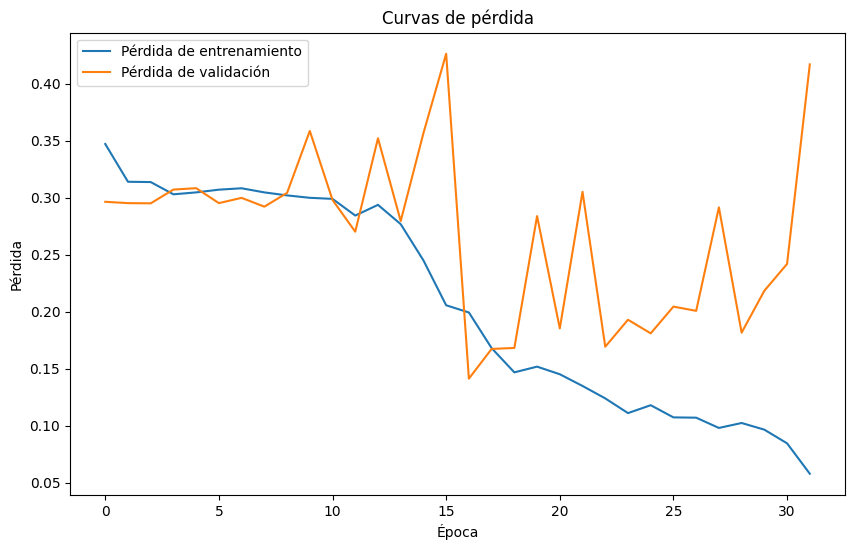

58/58 [==============================] - 1s 15ms/step
Resultados en prueba:
Precisión en prueba: 0.9476
Pérdida en prueba: 0.1412
AUC en prueba: 0.9672
Matriz de confusión en prueba:
[[ 12   8]
 [  4 205]]
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        20
           1       0.96      0.98      0.97       209

    accuracy                           0.95       229
   macro avg       0.86      0.79      0.82       229
weighted avg       0.94      0.95      0.94       229



In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con arquitectura fija
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs


    # Codificación posicional con head_size=64
    x = PositionalEncoding(input_shape[0], 64)(inputs)

    # Capas Conv1D iniciales: num_initial_conv=2, conv_filters=64
    for _ in range(2):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)

    # Capas Transformer: num_layers=1
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas: dense_units = [128, 64]
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)

# Graficar las curvas de pérdida y validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curvas de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


###Modelo con (2) conv1 antes del positional Encoding

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_11 (Conv1D)          (None, 5000, 64)             256       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_7 (Bat  (None, 5000, 64)             256       ['conv1d_11[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 conv1d_12 (Conv1D)          (None, 5000, 64)             12352     ['batch_normalization_7[

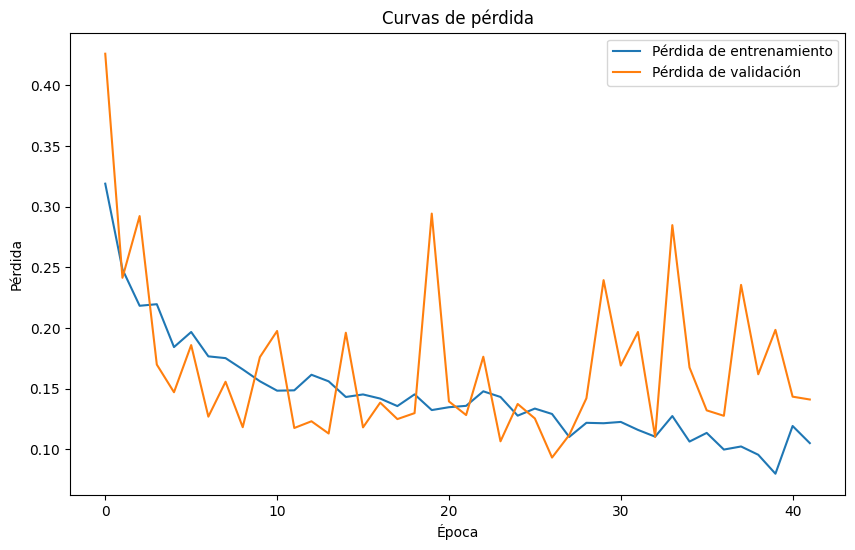

58/58 [==============================] - 1s 14ms/step
Resultados en prueba:
Precisión en prueba: 0.9694
Pérdida en prueba: 0.0932
AUC en prueba: 0.9864
Matriz de confusión en prueba:
[[ 14   6]
 [  1 208]]
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.93      0.70      0.80        20
           1       0.97      1.00      0.98       209

    accuracy                           0.97       229
   macro avg       0.95      0.85      0.89       229
weighted avg       0.97      0.97      0.97       229



In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con arquitectura fija
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for _ in range(2):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)

    # Codificación posicional con head_size=64
    x = PositionalEncoding(input_shape[0], 64)(x)

    # Capas Transformer: num_layers=1
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas: dense_units = [128, 64]
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)

# Graficar las curvas de pérdida y validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curvas de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


###Modelo con (1) conv1 antes del positional Encoding

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_9 (Conv1D)           (None, 5000, 64)             256       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 5000, 64)             256       ['conv1d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 positional_encoding_3 (Pos  (None, 5000, 64)             0         ['batch_normalization_6[

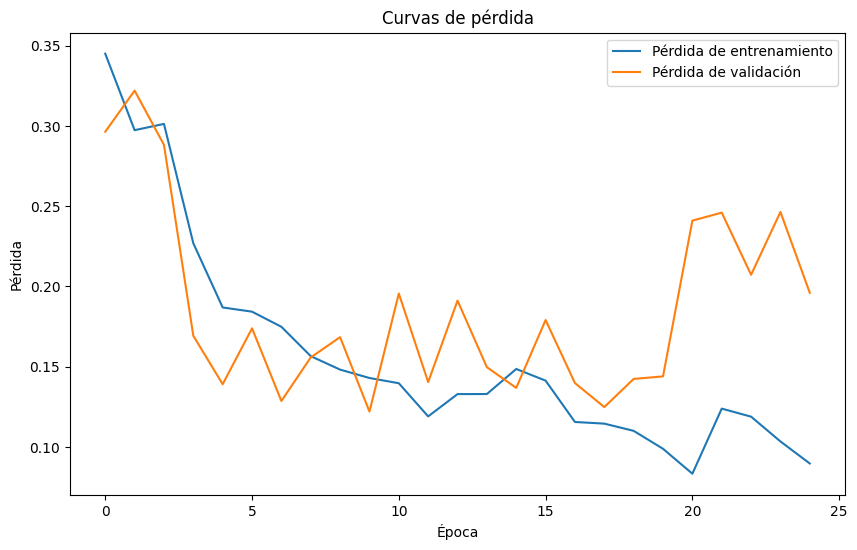

58/58 [==============================] - 1s 13ms/step
Resultados en prueba:
Precisión en prueba: 0.9563
Pérdida en prueba: 0.1221
AUC en prueba: 0.9675
Matriz de confusión en prueba:
[[ 15   5]
 [  5 204]]
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        20
           1       0.98      0.98      0.98       209

    accuracy                           0.96       229
   macro avg       0.86      0.86      0.86       229
weighted avg       0.96      0.96      0.96       229



In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con arquitectura fija
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for _ in range(1):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)

    # Codificación posicional con head_size=64
    x = PositionalEncoding(input_shape[0], 64)(x)

    # Capas Transformer: num_layers=1
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas: dense_units = [128, 64]
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)

# Graficar las curvas de pérdida y validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curvas de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


### Modelo con Max pooling ( Conv1D incial)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_17 (Conv1D)          (None, 5000, 64)             256       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_11 (Ba  (None, 5000, 64)             256       ['conv1d_17[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling1d_6 (MaxPoolin  (None, 2500, 64)             0         ['batch_normalization_11

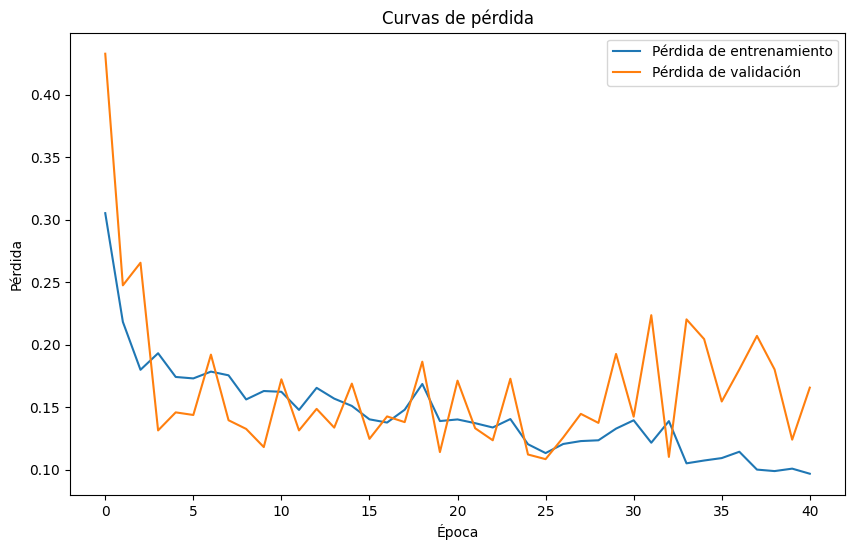

58/58 [==============================] - 0s 2ms/step
Resultados en prueba:
Precisión en prueba: 0.9520
Pérdida en prueba: 0.1085
AUC en prueba: 0.9761
Matriz de confusión en prueba:
[[ 12   8]
 [  3 206]]
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.80      0.60      0.69        20
           1       0.96      0.99      0.97       209

    accuracy                           0.95       229
   macro avg       0.88      0.79      0.83       229
weighted avg       0.95      0.95      0.95       229



In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con arquitectura fija
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for _ in range(2):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)

    # Codificación posicional con head_size=64
    x = PositionalEncoding(input_shape[0], 64)(x)

    # Capas Transformer: num_layers=1
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas: dense_units = [128, 64]
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)

# Graficar las curvas de pérdida y validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curvas de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


### Modelo con Max pooling (En feed foward) ( 2 Conv1D Solo Conv +bachregulation )

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_22 (Conv1D)          (None, 5000, 64)             256       ['input_9[0][0]']             
                                                                                                  
 batch_normalization_14 (Ba  (None, 5000, 64)             256       ['conv1d_22[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_23 (Conv1D)          (None, 5000, 64)             12352     ['batch_normalization_14

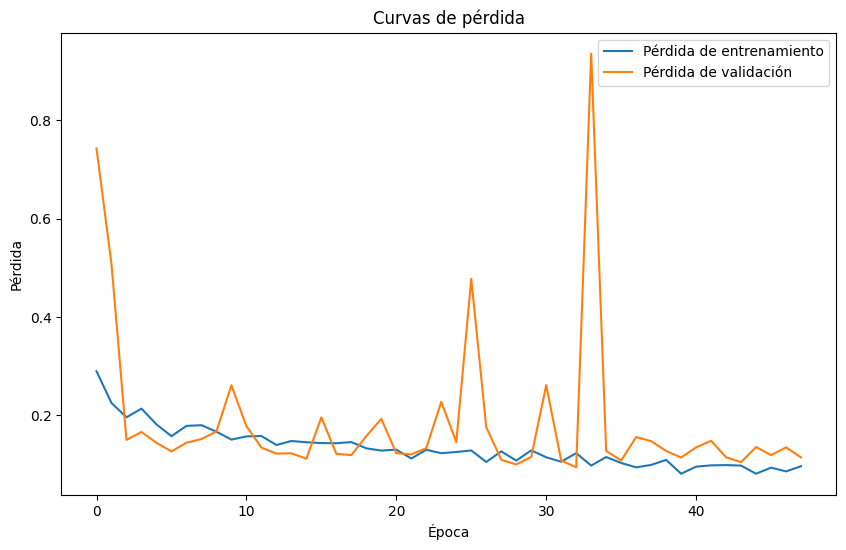

58/58 [==============================] - 1s 15ms/step
Resultados en prueba:
Precisión en prueba: 0.9651
Pérdida en prueba: 0.0948
AUC en prueba: 0.9782
Matriz de confusión en prueba:
[[ 15   5]
 [  3 206]]
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.98      0.99      0.98       209

    accuracy                           0.97       229
   macro avg       0.90      0.87      0.89       229
weighted avg       0.96      0.97      0.96       229



In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con arquitectura fija
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for _ in range(2):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)

    # Codificación posicional con head_size=64
    x = PositionalEncoding(input_shape[0], 64)(x)

    # Capas Transformer: num_layers=1
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas: dense_units = [128, 64]
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)

# Graficar las curvas de pérdida y validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curvas de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


### Modelo con Max pooling (1 Conv1D incial)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_20 (Conv1D)          (None, 5000, 64)             256       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_13 (Ba  (None, 5000, 64)             256       ['conv1d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling1d_9 (MaxPoolin  (None, 2500, 64)             0         ['batch_normalization_13

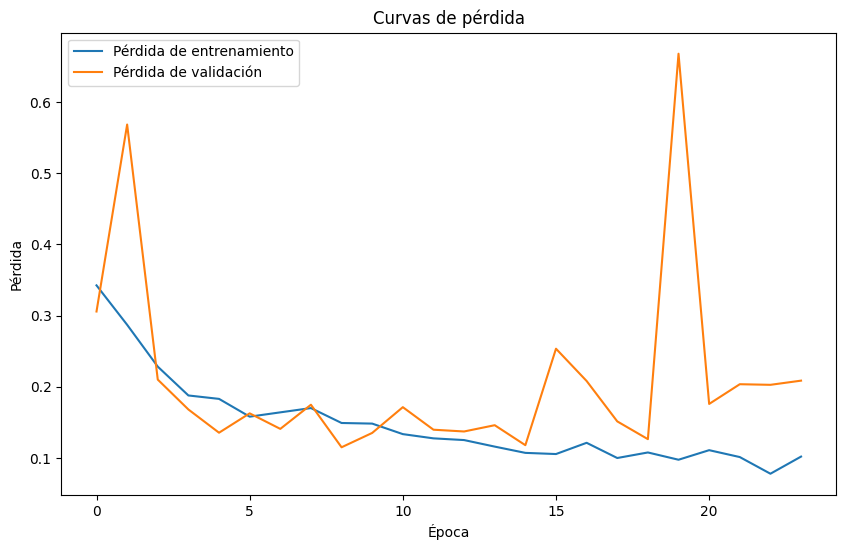

58/58 [==============================] - 1s 6ms/step
Resultados en prueba:
Precisión en prueba: 0.9607
Pérdida en prueba: 0.1150
AUC en prueba: 0.9711
Matriz de confusión en prueba:
[[ 14   6]
 [  3 206]]
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.82      0.70      0.76        20
           1       0.97      0.99      0.98       209

    accuracy                           0.96       229
   macro avg       0.90      0.84      0.87       229
weighted avg       0.96      0.96      0.96       229



In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con arquitectura fija
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for _ in range(1):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)

    # Codificación posicional con head_size=64
    x = PositionalEncoding(input_shape[0], 64)(x)

    # Capas Transformer: num_layers=1
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas: dense_units = [128, 64]
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)

# Graficar las curvas de pérdida y validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curvas de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


### Modelo con Maxpooling + Conv1D antes del position

###Modelo con maxPooling + Conv1 Antes + Conv1D Casual Dilatada

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_27 (Conv1D)          (None, 5000, 64)             256       ['input_11[0][0]']            
                                                                                                  
 batch_normalization_18 (Ba  (None, 5000, 64)             256       ['conv1d_27[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_28 (Conv1D)          (None, 5000, 64)             12352     ['batch_normalization_18

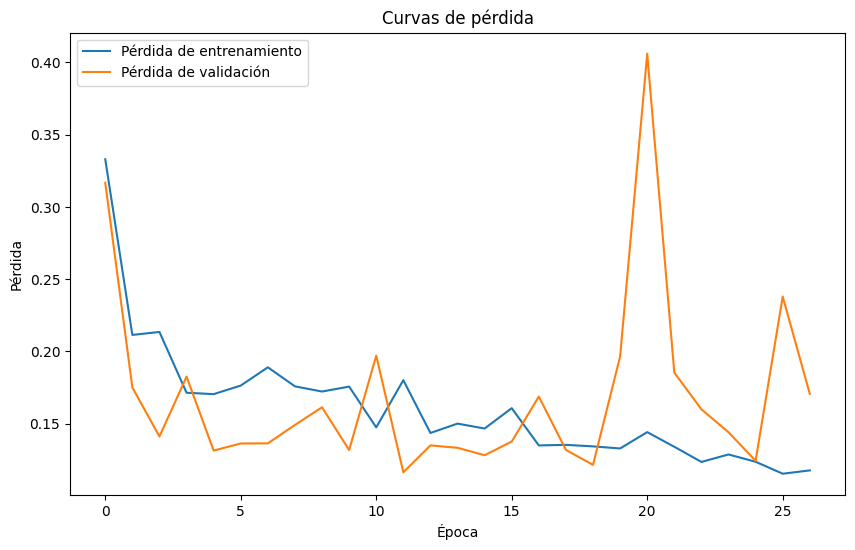

58/58 [==============================] - 1s 6ms/step
Resultados en prueba:
Precisión en prueba: 0.9563
Pérdida en prueba: 0.1163
AUC en prueba: 0.9737
Matriz de confusión en prueba:
[[ 11   9]
 [  1 208]]
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.92      0.55      0.69        20
           1       0.96      1.00      0.98       209

    accuracy                           0.96       229
   macro avg       0.94      0.77      0.83       229
weighted avg       0.95      0.96      0.95       229



In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con convoluciones causales dilatadas
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Capas Conv1D iniciales con convolución causal dilatada
    x = inputs
    dilation_rates = [1, 2]  # Puedes ajustar estos valores
    for dilation_rate in dilation_rates:
        x = layers.Conv1D(
            filters=64,
            kernel_size=3,
            padding='causal',
            dilation_rate=dilation_rate,
            activation='relu'
        )(x)
        x = layers.BatchNormalization()(x)
    # Añadir MaxPooling después de las capas Conv1D (opcional)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Codificación posicional
    x = PositionalEncoding(input_shape[0],64)(x)

    # Capas Transformer
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)

# Graficar las curvas de pérdida y validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curvas de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_35 (Conv1D)          (None, 5000, 64)             256       ['input_14[0][0]']            
                                                                                                  
 batch_normalization_24 (Ba  (None, 5000, 64)             256       ['conv1d_35[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_36 (Conv1D)          (None, 5000, 64)             12352     ['batch_normalization_2

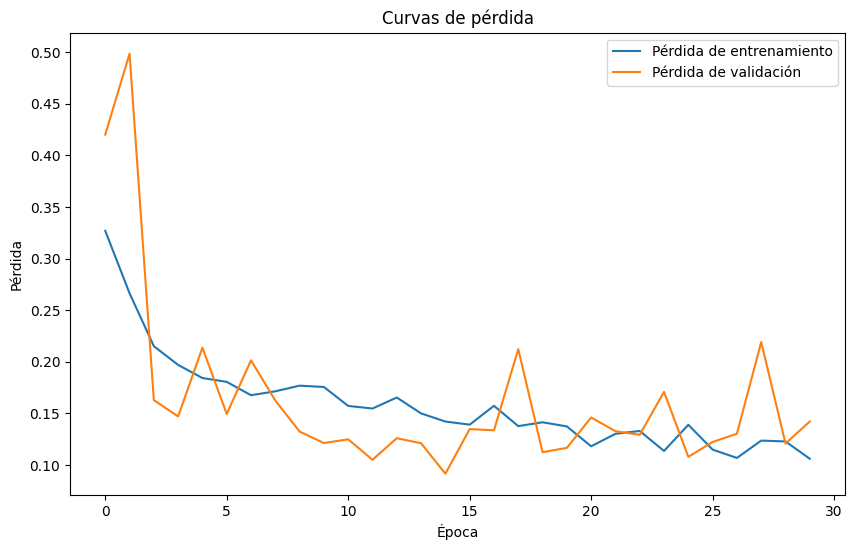

58/58 [==============================] - 1s 15ms/step
Resultados en prueba:
Precisión en prueba: 0.9782
Pérdida en prueba: 0.0916
AUC en prueba: 0.9825
Matriz de confusión en prueba:
[[ 16   4]
 [  1 208]]
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.94      0.80      0.86        20
           1       0.98      1.00      0.99       209

    accuracy                           0.98       229
   macro avg       0.96      0.90      0.93       229
weighted avg       0.98      0.98      0.98       229



In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con convoluciones causales dilatadas
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Capas Conv1D iniciales con convolución causal dilatada
    x = inputs
    dilation_rates = [1, 2]  # Puedes ajustar estos valores
    for dilation_rate in dilation_rates:
        x = layers.Conv1D(
            filters=64,
            kernel_size=3,
            padding='causal',
            dilation_rate=dilation_rate,
            activation='relu'
        )(x)
        x = layers.BatchNormalization()(x)

    # Codificación posicional
    x = PositionalEncoding(input_shape[0],64)(x)

    # Capas Transformer
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)

plt.figure(figsize=(12, 5))

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Curva de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_56 (Conv1D)          (None, 5000, 64)             256       ['input_18[0][0]']            
                                                                                                  
 batch_normalization_36 (Ba  (None, 5000, 64)             256       ['conv1d_56[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_57 (Conv1D)          (None, 5000, 64)             12352     ['batch_normalization_3

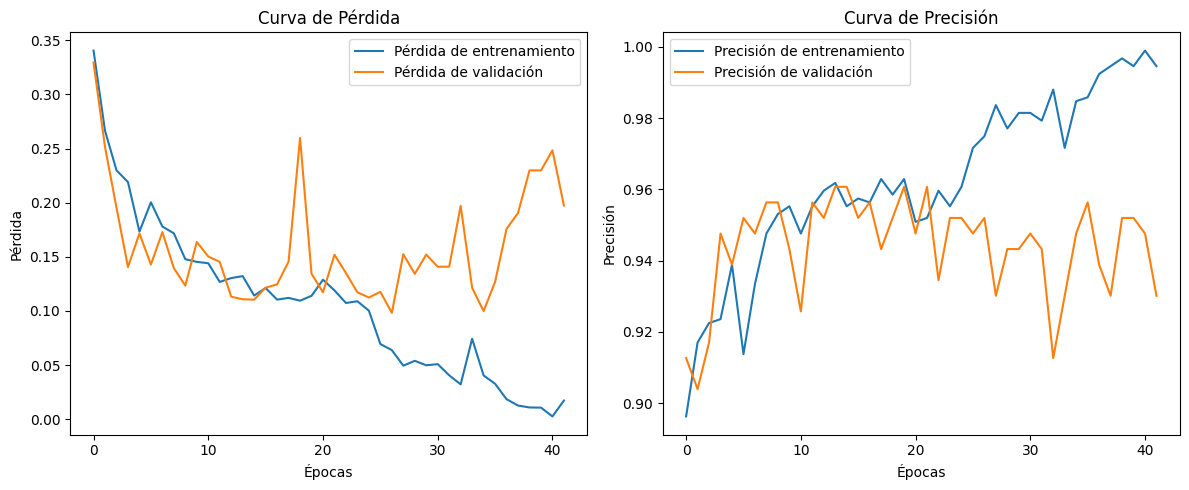

58/58 [==============================] - 1s 16ms/step
Resultados en prueba:
Precisión en prueba: 0.9520
Pérdida en prueba: 0.0983
AUC en prueba: 0.9821
Matriz de confusión en prueba:
[[ 12   8]
 [  3 206]]
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.80      0.60      0.69        20
           1       0.96      0.99      0.97       209

    accuracy                           0.95       229
   macro avg       0.88      0.79      0.83       229
weighted avg       0.95      0.95      0.95       229



In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con convoluciones causales dilatadas
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Capas Conv1D iniciales con convolución causal dilatada
    x = inputs
    dilation_rates = [1, 2, 4, 8]  # Puedes ajustar estos valores
    for dilation_rate in dilation_rates:
        x = layers.Conv1D(
            filters=64,
            kernel_size=3,
            padding='causal',
            dilation_rate=dilation_rate,
            activation='relu'
        )(x)
        x = layers.BatchNormalization()(x)

    # Codificación posicional
    x = PositionalEncoding(input_shape[0],64)(x)

    # Capas Transformer
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, verbose=1
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

plt.figure(figsize=(12, 5))

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Curva de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con convoluciones causales dilatadas
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Capas Conv1D iniciales con convolución causal dilatada
    x = inputs
    for _ in range(2):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)

    # Codificación posicional
    x = PositionalEncoding(input_shape[0],64)(x)

    # Capas Transformer
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, verbose=1
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

plt.figure(figsize=(12, 5))

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Curva de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_61 (Conv1D)          (None, 5000, 64)             256       ['input_19[0][0]']            
                                                                                                  
 batch_normalization_40 (Ba  (None, 5000, 64)             256       ['conv1d_61[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_62 (Conv1D)          (None, 5000, 64)             12352     ['batch_normalization_4

KeyboardInterrupt: 

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_64 (Conv1D)          (None, 5000, 64)             256       ['input_20[0][0]']            
                                                                                                  
 batch_normalization_42 (Ba  (None, 5000, 64)             256       ['conv1d_64[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling1d_29 (MaxPooli  (None, 2500, 64)             0         ['batch_normalization_4

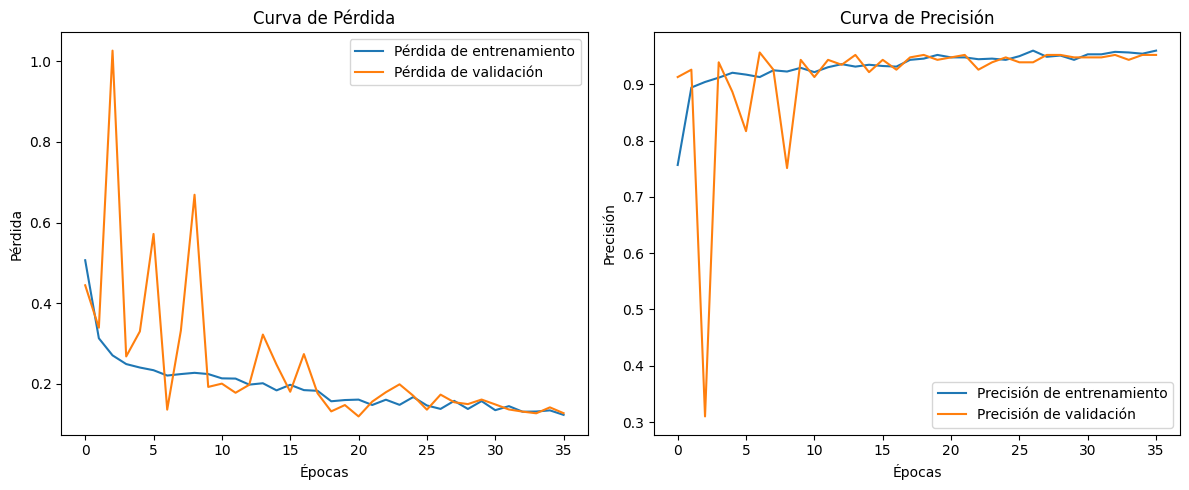

58/58 [==============================] - 1s 7ms/step
Resultados en prueba:
Precisión en prueba: 0.9476
Pérdida en prueba: 0.1192
AUC en prueba: 0.9799
Matriz de confusión en prueba:
[[ 12   8]
 [  4 205]]
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        20
           1       0.96      0.98      0.97       209

    accuracy                           0.95       229
   macro avg       0.86      0.79      0.82       229
weighted avg       0.94      0.95      0.94       229



In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con convoluciones causales dilatadas
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Capas Conv1D iniciales con convolución causal dilatada
    x = inputs
    for _ in range(2):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)

    # Codificación posicional
    x = PositionalEncoding(input_shape[0],64)(x)

    # Capas Transformer
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, verbose=1
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

plt.figure(figsize=(12, 5))

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Curva de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_70 (Conv1D)          (None, 5000, 64)             256       ['input_22[0][0]']            
                                                                                                  
 batch_normalization_50 (Ba  (None, 5000, 64)             256       ['conv1d_70[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv1d_71 (Conv1D)          (None, 5000, 64)             12352     ['batch_normalization_5

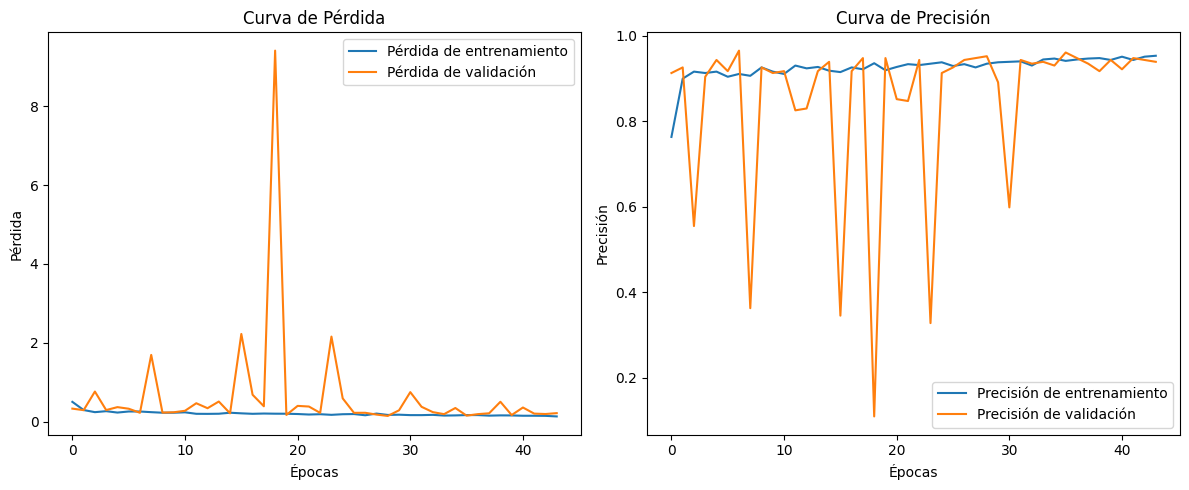

58/58 [==============================] - 1s 6ms/step
Resultados en prueba:
Precisión en prueba: 0.9520
Pérdida en prueba: 0.1470
AUC en prueba: 0.9545
Matriz de confusión en prueba:
[[ 13   7]
 [  4 205]]
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        20
           1       0.97      0.98      0.97       209

    accuracy                           0.95       229
   macro avg       0.87      0.82      0.84       229
weighted avg       0.95      0.95      0.95       229



In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con convoluciones causales dilatadas
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Capas Conv1D iniciales con convolución causal dilatada
    x = inputs
    for _ in range(2):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)

    x = layers.MaxPooling1D(pool_size=2)(x)

    # Codificación posicional
    x = PositionalEncoding(input_shape[0],64)(x)

    # Capas Transformer
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, verbose=1
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

plt.figure(figsize=(12, 5))

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Curva de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_67 (Conv1D)          (None, 5000, 64)             256       ['input_21[0][0]']            
                                                                                                  
 batch_normalization_46 (Ba  (None, 5000, 64)             256       ['conv1d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling1d_32 (MaxPooli  (None, 2500, 64)             0         ['batch_normalization_4

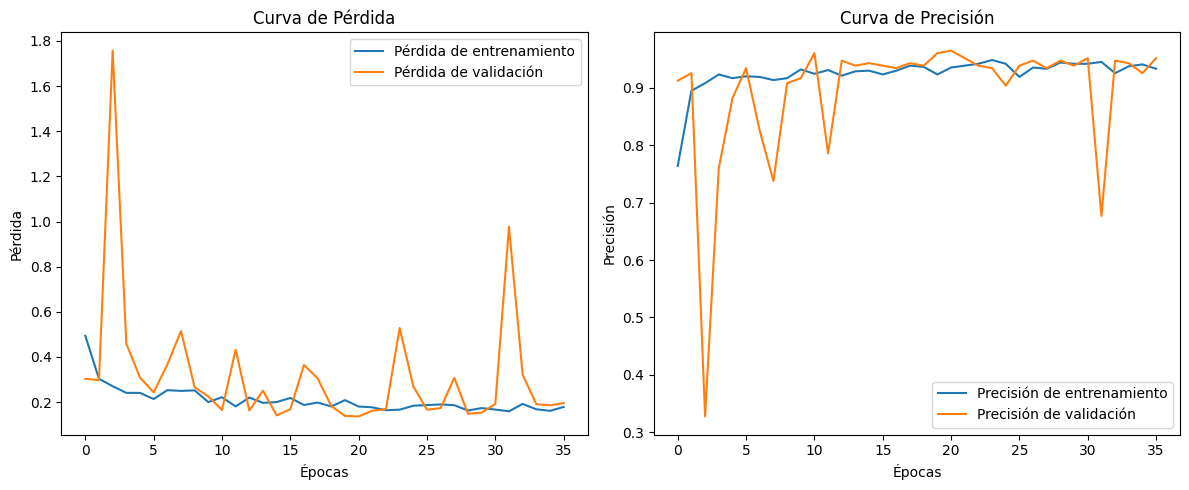

58/58 [==============================] - 1s 6ms/step
Resultados en prueba:
Precisión en prueba: 0.9651
Pérdida en prueba: 0.1365
AUC en prueba: 0.9567
Matriz de confusión en prueba:
[[ 13   7]
 [  1 208]]
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.93      0.65      0.76        20
           1       0.97      1.00      0.98       209

    accuracy                           0.97       229
   macro avg       0.95      0.82      0.87       229
weighted avg       0.96      0.97      0.96       229



In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con convoluciones causales dilatadas
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Capas Conv1D iniciales con convolución causal dilatada
    x = inputs
    for _ in range(2):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)

    # Codificación posicional
    x = PositionalEncoding(input_shape[0],64)(x)

    # Capas Transformer
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, verbose=1
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)

plt.figure(figsize=(12, 5))

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Curva de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


## + LSTM

### Modelo con Max pooling (En feed foward) ( 2 Conv1D Solo Conv +bachregulation ) + LSTM

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_41 (Conv1D)          (None, 5000, 64)             256       ['input_16[0][0]']            
                                                                                                  
 batch_normalization_28 (Ba  (None, 5000, 64)             256       ['conv1d_41[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling1d_16 (MaxPooli  (None, 2500, 64)             0         ['batch_normalization_2

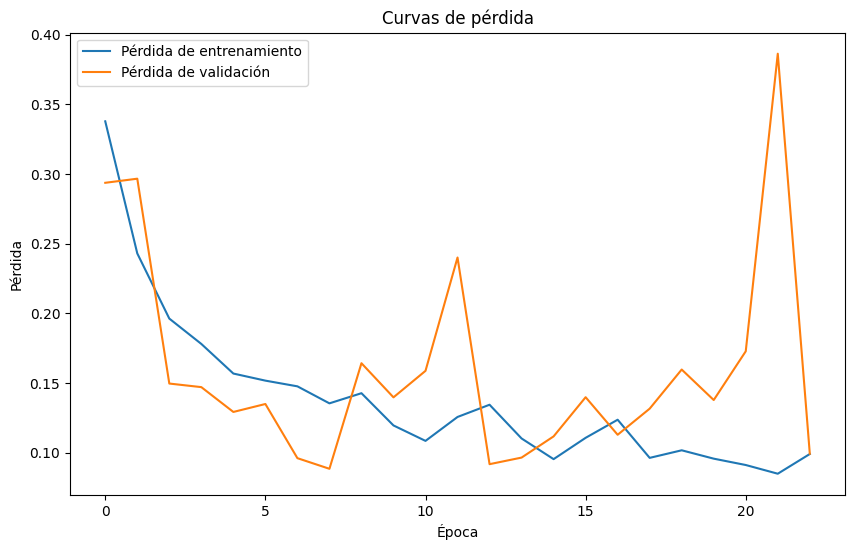

58/58 [==============================] - 2s 29ms/step
Resultados en prueba:
Precisión en prueba: 0.9651
Pérdida en prueba: 0.0886
AUC en prueba: 0.9873
Matriz de confusión en prueba:
[[ 15   5]
 [  3 206]]
Reporte de clasificación en prueba:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.98      0.99      0.98       209

    accuracy                           0.97       229
   macro avg       0.90      0.87      0.89       229
weighted avg       0.96      0.97      0.96       229



In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con arquitectura fija
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for _ in range(2):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)



    # Codificación posicional con head_size=64
    x = PositionalEncoding(input_shape[0], 64)(x)

    # Capas Transformer: num_layers=1
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas: dense_units = [128, 64]
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)

# Graficar las curvas de pérdida y validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curvas de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con convoluciones causales dilatadas
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Capas Conv1D iniciales con convolución causal dilatada
    x = inputs
    for _ in range(2):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LSTM(64, return_sequences=True)(x)
    # Codificación posicional
    x = PositionalEncoding(input_shape[0],64)(x)

    # Capas Transformer
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, verbose=1
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

plt.figure(figsize=(12, 5))

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Curva de Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 5000, 1)]            0         []                            
                                                                                                  
 conv1d_76 (Conv1D)          (None, 5000, 64)             256       ['input_24[0][0]']            
                                                                                                  
 batch_normalization_58 (Ba  (None, 5000, 64)             256       ['conv1d_76[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling1d_39 (MaxPooli  (None, 2500, 64)             0         ['batch_normalization_5

###Modelo con maxPooling + Conv1 Antes + Conv1D Casual Dilatada + LSTM

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Supongamos que 'df_filtered' es tu DataFrame filtrado
# Reemplaza esta parte con tus datos reales
num_samples = 100
sequence_length = 200
X = np.random.rand(num_samples, sequence_length, 1)
y = np.random.randint(0, 2, num_samples)

# Añadimos una dimensión extra si es necesario
if len(X.shape) == 2:
    X = np.expand_dims(X, -1)

print(f"Tipo de X: {X.dtype}, Tipo de y: {y.dtype}")
print(f'Datos: {X.shape}')

# División de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Definición de la capa de codificación posicional
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model

    def call(self, inputs):
        sequence_length = tf.shape(inputs)[1]
        position = tf.cast(tf.range(sequence_length)[:, tf.newaxis], tf.float32)
        i = tf.cast(tf.range(self.d_model)[tf.newaxis, :], tf.float32)
        angle_rates = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(self.d_model, tf.float32))
        angle_rads = position * angle_rates

        # Aplicar sin a índices pares
        sines = tf.sin(angle_rads[:, 0::2])

        # Aplicar cos a índices impares
        cosines = tf.cos(angle_rads[:, 1::2])

        # Concatenar sines y cosines
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return inputs + pos_encoding

# Modificación de la función del encoder del Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks=1, num_ff_layers=1, dropout=0):
    x = inputs
    for _ in range(num_transformer_blocks):
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        x = x + x1  # Conexión residual

        x2 = x
        for _ in range(num_ff_layers):
            x2 = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x2)
            x2 = layers.Dropout(dropout)(x2)
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x = x + x2  # Otra conexión residual
    return x

# Función para construir el modelo Transformer con una capa LSTM adicional
def build_transformer_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Capas Conv1D iniciales con convolución causal dilatada
    x = inputs
    dilation_rates = [1, 2, 4]  # Puedes ajustar estos valores
    for dilation_rate in dilation_rates:
        x = layers.Conv1D(
            filters=64,
            kernel_size=3,
            padding='causal',
            dilation_rate=dilation_rate,
            activation='relu'
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)

    # Añadir una capa LSTM
    x = layers.LSTM(64, return_sequences=True)(x)

    # Codificación posicional
    x = PositionalEncoding(64)(x)

    # Capas Transformer
    for _ in range(1):
        x = transformer_encoder(
            x,
            head_size=64,
            num_heads=2,
            ff_dim=64,
            num_transformer_blocks=1,
            num_ff_layers=1,
            dropout=0.1
        )

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Capas densas
    for units in [128, 64]:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(0.1)(x)

    # Capa de salida
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Construir el modelo
model = build_transformer_model(
    input_shape=(X_train_full.shape[1], X_train_full.shape[2]),
    num_classes=2
)

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

# Imprimir el resumen del modelo
model.summary()

# Definir early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    X_train_full, y_train_full,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)

# Graficar las curvas de pérdida y validación
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curvas de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Evaluar el modelo en el conjunto de prueba
y_test_probs = model.predict(X_test, batch_size=4)
y_test_pred = np.argmax(y_test_probs, axis=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
test_auc = roc_auc_score(y_test, y_test_probs[:, 1])
test_confusion = confusion_matrix(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Resultados en prueba:")
print(f"Precisión en prueba: {test_accuracy:.4f}")
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"AUC en prueba: {test_auc:.4f}")
print(f"Matriz de confusión en prueba:\n{test_confusion}")
print(f"Reporte de clasificación en prueba:\n{test_classification_report}")


## ULTIMOS MODELOS